## Reproducing Fig. 3 of K01

CAVEAT: To ensure consistency with the Kepert figures and the notebook 00_Test_Fig3_K01.ipynb that checks the Kepert model at the surface (z=0), I had to modify the beginning of the function get_z_kepert(). Ensure to check that if I use the present functions in an other notebook (i.e if I export these functions I need to apply the correction factor to Vs and convert it to Vs_try. Additionally I might want to add the storm motion Ut != 0 to convert from storm-relative winds to absolute/observed winds) for other checks (not done in Kepert, so not done here!).

I still have a small difference in my w(z=2000m) computation, compared to Kepert 2001. Maybe Kepert uses the analytical solution, while I integrate the continuity equation. 

The way I add the storm motion vector seems correct, although I cannot be sure as I don't really know the exact definitions used by Kepert...

In [1]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.interpolate import griddata

# Statistics
from sklearn import linear_model, neighbors

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
#########################
### General functions ###
#########################
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter assuming it's constant 
    return fcor

def holland_profile(r, lat, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor   = abs(coriolis(lat))
    rho    = 1.15
    r      = r.astype(float) + 0.001           # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt( ((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

#########################
### KEPERT 2001 MODEL ###
#########################
# Inertial stability
def I(Rs, Vs, fcor):
    dr   = np.diff(Rs[0, :])[0] # meters
    ksi  = 2 * Vs / Rs + fcor
    zeta = np.gradient(Vs, dr, axis=1) + Vs / Rs + fcor
    return np.sqrt(ksi * zeta)

# Coefficients
def sqrt_alpha_beta(Rs, Vs, fcor):
    '''Corresponds to sqrt(alpha / beta).'''
    dr   = np.diff(Rs[0, :])[0] # meteRs
    ksi  = 2 * Vs / Rs + fcor
    zeta = np.gradient(Vs, dr, axis=1) + Vs / Rs + fcor
    return np.sqrt(ksi / zeta)

def eta(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / (K * ((Vs / Rs) + I(Rs, Vs, fcor))))

def ki(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / (K * I(Rs, Vs, fcor)))

def psi(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / abs(K * ((Vs / Rs) - I(Rs, Vs, fcor))))

# Amplitudes
def A0(Rs, Vs, K, C, fcor):
    num = -ki(Rs, Vs, K, C, fcor) * Vs * [1 + 1j * (1 + ki(Rs, Vs, K, C, fcor))]
    den = 2 * ki(Rs, Vs, K, C, fcor) ** 2 + 3 * ki(Rs, Vs, K, C, fcor) + 2
    return num / den

def A1(Rs, Vs, Ut, K, C, fcor):
    num = -eta(Rs, Vs, K, C, fcor) * Ut * [1 - 2 * sqrt_alpha_beta(Rs, Vs, fcor) + (1 + 1j) * (1 - sqrt_alpha_beta(Rs, Vs, fcor)) * psi(Rs, Vs, K, C, fcor)]
    den = sqrt_alpha_beta(Rs, Vs, fcor) * [(2 + 2j) * (1 + eta(Rs, Vs, K, C, fcor) * psi(Rs, Vs, K, C, fcor)) + 3 * eta(Rs, Vs, K, C, fcor) + 3j * psi(Rs, Vs, K, C, fcor)]
    return num / den

def A_1(Rs, Vs, Ut, K, C, fcor):
    num = -psi(Rs, Vs, K, C, fcor) * Ut * [1 + 2 * sqrt_alpha_beta(Rs, Vs, fcor) + (1 + 1j) * (1 + sqrt_alpha_beta(Rs, Vs, fcor)) * eta(Rs, Vs, K, C, fcor)]
    den = sqrt_alpha_beta(Rs, Vs, fcor) * [(2 + 2j) * (1 + eta(Rs, Vs, K, C, fcor) * psi(Rs, Vs, K, C, fcor)) + 3 * psi(Rs, Vs, K, C, fcor) + 3j * eta(Rs, Vs, K, C, fcor)]
    return num / den

def A1_prime(Rs, Vs, Ut, K, C, fcor):
    num = -eta(Rs, Vs, K, C, fcor) * Ut * [1 - 2 * sqrt_alpha_beta(Rs, Vs, fcor) + (1 - 1j) * (1 - sqrt_alpha_beta(Rs, Vs, fcor)) * psi(Rs, Vs, K, C, fcor)]
    den = sqrt_alpha_beta(Rs, Vs, fcor) * [2 + 2j + 3 * (eta(Rs, Vs, K, C, fcor) + psi(Rs, Vs, K, C, fcor)) + (2 - 2j) * eta(Rs, Vs, K, C, fcor) * psi(Rs, Vs, K, C, fcor)]
    return num / den

def A_1_prime(Rs, Vs, Ut, K, C, fcor):
    num = -psi(Rs, Vs, K, C, fcor) * Ut * [1 + 2 * sqrt_alpha_beta(Rs, Vs, fcor) + (1 + 1j) * (1 + sqrt_alpha_beta(Rs, Vs, fcor)) * eta(Rs, Vs, K, C, fcor)]
    den = sqrt_alpha_beta(Rs, Vs, fcor) * [2 - 2j + 3 * (eta(Rs, Vs, K, C, fcor) + psi(Rs, Vs, K, C, fcor)) + (2 + 2j) * eta(Rs, Vs, K, C, fcor) * psi(Rs, Vs, K, C, fcor)]
    return num / den

# Thicknesses
def delta0(Rs, Vs, K, fcor):
    return np.sqrt(2 * K / abs(I(Rs, Vs, fcor)))

def delta1(Rs, Vs, K, fcor):
    return np.sqrt(2 * K / abs(I(Rs, Vs, fcor) + Vs / Rs))

def delta_1(Rs, Vs, K, fcor):
    return np.sqrt(2 * K / abs(I(Rs, Vs, fcor) - Vs / Rs))

# Radial and tangential wind components
def u0(Rs, Vs, K, C, fcor, z):
    u0 = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A0(Rs, Vs, K, C, fcor) * np.exp(- (1 + 1j) * z / delta0(Rs, Vs, K, fcor)))
    return np.reshape(u0,  np.shape(u0)[1:])

def v0(Rs, Vs, K, C, fcor, z):
    v0 = np.imag(A0(Rs, Vs, K, C, fcor) * np.exp(- (1 + 1j) * z / delta0(Rs, Vs, K, fcor)))
    return np.reshape(v0,  np.shape(v0)[1:])

def u1(THs, Rs, Vs, Ut, K, C, fcor, z):
    u1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A1(Rs, Vs, Ut, K, C, fcor)       * np.exp(- (1 + 1j) * z / delta1(Rs, Vs, K, fcor) + 1j * THs))
    otherwise = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A1_prime(Rs, Vs, Ut, K, C, fcor) * np.exp(- (1 + 1j) * z / delta1(Rs, Vs, K, fcor) + 1j * THs))
    u1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    u1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return u1

def v1(THs, Rs, Vs, Ut, K, C, fcor, z):
    v1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = np.imag(A1(Rs, Vs, Ut, K, C, fcor)       * np.exp(- (1 + 1j) * z / delta1(Rs, Vs, K, fcor) + 1j * THs))
    otherwise = np.imag(A1_prime(Rs, Vs, Ut, K, C, fcor) * np.exp(- (1 + 1j) * z / delta1(Rs, Vs, K, fcor) + 1j * THs))
    v1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    v1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return v1

def u_1(THs, Rs, Vs, Ut, K, C, fcor, z):
    u1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A_1(Rs, Vs, Ut, K, C, fcor)       * np.exp(- (1 + 1j) * z / delta_1(Rs, Vs, K, fcor) - 1j * THs))
    otherwise = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A_1_prime(Rs, Vs, Ut, K, C, fcor) * np.exp(- (1 - 1j) * z / delta_1(Rs, Vs, K, fcor) - 1j * THs))
    u1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    u1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return u1

def v_1(THs, Rs, Vs, Ut, K, C, fcor, z):
    v1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = np.imag(A_1(Rs, Vs, Ut, K, C, fcor)       * np.exp(- (1 + 1j) * z / delta_1(Rs, Vs, K, fcor) - 1j * THs))
    otherwise = np.imag(A_1_prime(Rs, Vs, Ut, K, C, fcor) * np.exp(- (1 - 1j) * z / delta_1(Rs, Vs, K, fcor) - 1j * THs))
    v1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    v1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return v1

# TOTAL WIND COMPONENTS IN THE BL
def u_BL(THs, Rs, Vs, Ut, K, C, fcor, z):
    return u_1(THs, Rs, Vs, Ut, K, C, fcor, z) + u0(Rs, Vs, K, C, fcor, z) + u1(THs, Rs, Vs, Ut, K, C, fcor, z)

def v_BL(THs, Rs, Vs, Ut, K, C, fcor, z):
    return Vs + v_1(THs, Rs, Vs, Ut, K, C, fcor, z) + v0(Rs, Vs, K, C, fcor, z) + v1(THs, Rs, Vs, Ut, K, C, fcor, z)

# FINAL MODEL
def kepert2001(THs, Rs, Vs, Ut, K, C, fcor, z):
    # Returns Kepert wind speeds
    u_K01   = u_BL(THs, Rs, Vs, Ut, K, C, fcor, z)
    v_K01   = v_BL(THs, Rs, Vs, Ut, K, C, fcor, z)  

    # # Adds the translation speed
    # Utu     = Ut * np.cos(THs) # Radial component of Ut
    # Utv     = - Ut * np.sin(THs) # Tangential component of Ut
    Utu = Utv = 0
    
    return u_K01 + Utu, v_K01 + Utv

#########################
### CREATE STRUCTURES ###
#########################
def get_xrDataset_polar(rs, ths, u_K01, v_K01):
    kep_pol = xr.Dataset(
        data_vars={
            'wind_speed': (('theta', 'rad'), np.sqrt(v_K01 ** 2 + u_K01 ** 2)),
            'rad_wind':   (('theta', 'rad'), u_K01),
            'tan_wind':   (('theta', 'rad'), v_K01),
        },
        coords={
            'theta': np.rad2deg(ths),
            'rad': rs,
        }
    )
    kep_pol['inflow_angle'] = np.rad2deg(np.arctan((kep_pol.rad_wind / kep_pol.tan_wind))) # Inflow Angle Polar
    return kep_pol

def get_xrDataset_cartesian(Xs, Ys, x_ref, y_ref, dim_ref, kep_pol):
    '''Slower than its polar counterpart, because 4 interpolations are performed.'''
    kep_car = xr.Dataset(
        data_vars={
            'wind_speed':   (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.wind_speed).flatten(),   (x_ref, y_ref), method='nearest')),
            'rad_wind':     (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.rad_wind).flatten(),     (x_ref, y_ref), method='nearest')),
            'tan_wind':     (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.tan_wind).flatten(),     (x_ref, y_ref), method='nearest')),
            'inflow_angle': (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.inflow_angle).flatten(), (x_ref, y_ref), method='nearest')),
        },
        coords={
            'x': dim_ref,
            'y': dim_ref,
        }
    )
    return kep_car

#########################
###   MODEL FITTING   ###
#########################
def wind_reduction_factor(Rs, Vs, K, C, fcor):
    '''wrf = surface azim. wind / gradient azim. wind'''
    ki_cst  = ki(Rs, Vs, K, C, fcor)
    num     = ki_cst ** 2 + 2 * ki_cst + 2
    den     = 2 * ki_cst ** 2 + 3 * ki_cst + 2
    return num / den

def wn1(thetas, a, phi, c):
    return a * np.cos(thetas + phi) + c

def get_wn1(thetas, wind_speed, initial_condition=15, upper_bound=80):
    '''
    initial_condition: initial conidition for the amplitude and the constant c (just put Vplus)
    upper_bound: upper bound for the the amplitude and the constant c (just put Vmax)
    '''
    # Fitting process
    popt, pcov = curve_fit(
        f=wn1,
        xdata=thetas,
        ydata=wind_speed,
        p0=[initial_condition, np.pi / 2, initial_condition],
        bounds=([1., 0., 0.1], [upper_bound, np.pi, upper_bound]) # ([lower bounds], [upper bounds])
    )
    a, phi, c = popt[0], popt[1], popt[2]
    return a, phi, c

def get_kepert_asymmetries(THs, Rs, ths, rs, Vs, Ut, K, C, fcr, valid_radii):
    # Estimate the wind at the top of the BL with the wind reduction factor
    wrf          = wind_reduction_factor(Rs, Vs, K, C, fcr) # azimuthal wind
    Vs_try       = Vs / wrf

    # Apply Kepert's model
    u_K01, v_K01 = kepert2001(THs, Rs, Vs_try, Ut, K, C, fcr) # Takes 3-4 seconds
    kep_pol      = get_xrDataset_polar(rs, ths, u_K01, v_K01)

    # Compute asymmetries on Kepert wind field
    aks         = []
    # Iterate over all radii
    for rad in tqdm(valid_radii): # Iterate only in the valid range to optimize time
        ak, _, _  = get_wn1(np.deg2rad(kep_pol.theta), kep_pol.wind_speed.sel(rad=rad, method='nearest'), np.max(Vs[0, :]) / 3, np.max(Vs[0, :]))
        aks.append(ak)
    
    return aks, kep_pol

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

#########################
###       PLOT        ###
#########################
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def getColorMap(rgbFile="medspiration.rgb"):
    '''
    Load a RGB palette provided in ascii file
    '''
    colors = []
    nbCol  =0
    for line in open( rgbFile ):
        r,g,b = [int(c) for c in line.split()]
        colors.append( [r/255.,g/255.,b/255.] )
        nbCol += 1
    return(mpl.colors.ListedColormap(colors, name="custom", N=nbCol))

palette      = '/home/arthur/scripts/tools/high_wind_speed.pal'
cwnd         = getColorMap(rgbFile=palette)
normalizer   = Normalize(0, 80)

In [3]:
def get_z_kepert(THs, Rs, ths, rs, zs, Vs, Ut, K, C, fcr):
    # # Estimate the wind at the top of the BL with the wind reduction factor
    # LINES TO UNCOMMENT, JUST FOR THE CHECKING NOTEBOOK
    # wrf          = wind_reduction_factor(Rs, Vs, K, C, fcr) # azimuthal wind
    # Vs_try       = Vs / wrf
    # And comment this line below instead:
    Vs_try = Vs

    # Apply Kepert's model at each z
    # TODO: Vectorize all my functions?
    U_K01, V_K01 = [], []
    for z in tqdm(zs):
        u_K01, v_K01 = kepert2001(THs, Rs, Vs_try, Ut, K, C, fcr, z) # Takes 3-4 seconds
        U_K01.append(u_K01)
        V_K01.append(v_K01)
    
    # Polar dataset
    kep_pol = xr.Dataset(
        data_vars={
            'wind_speed': (('z', 'theta', 'rad'), np.sqrt(np.array(V_K01) ** 2 + np.array(U_K01) ** 2)),
            'rad_wind':   (('z', 'theta', 'rad'), np.array(U_K01)),
            'tan_wind':   (('z', 'theta', 'rad'), np.array(V_K01)),
        },
        coords={
            'z': zs,
            'theta': np.rad2deg(ths),
            'rad': rs,
        }
    )
    kep_pol['inflow_angle'] = np.rad2deg(np.arctan((kep_pol.rad_wind / kep_pol.tan_wind))) # Inflow Angle Polar
    print('Polar dataset created.')

    # Cartesian dataset
    KEP_CARS = []
    for z in tqdm(zs): # Takes ~20 seconds
        kep_car = xr.Dataset(
            data_vars={
                'wind_speed':   (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.sel(z=z).wind_speed).flatten(),   (x_ref, y_ref), method='nearest')),
                'rad_wind':     (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.sel(z=z).rad_wind).flatten(),     (x_ref, y_ref), method='nearest')),
                'tan_wind':     (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.sel(z=z).tan_wind).flatten(),     (x_ref, y_ref), method='nearest')),
                'inflow_angle': (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.sel(z=z).inflow_angle).flatten(), (x_ref, y_ref), method='nearest')),
            },
            coords={
                'x': dim_ref,
                'y': dim_ref,
            }
        )
        KEP_CARS.append(kep_car)
    kep_car = xr.concat(KEP_CARS, 'z').assign_coords({'z': zs})
    print('Cartesian dataset created.')

    return kep_pol, kep_car

In [4]:
#########################
###  HYPERPARAMETERS  ###
#########################
# Reference grids
rs           = np.linspace(100, 5e5, 5000)
ths          = np.linspace(0, 2 * np.pi, 361)                         # in radians
zs           = np.array([0, 500, 1000, 2000])                         # in meters
Rs, THs      = np.meshgrid(rs, ths)                                   # shape (361, 5000)
Xs, Ys       = pol2cart(Rs, THs)                                      # to create cartesian dataset
dim_ref      = np.linspace(-500, 500, int((500 // 1 * 2) + 1)) * 1000 # to create cartesian dataset
x_ref, y_ref = np.meshgrid(dim_ref, dim_ref)                          # to create cartesian dataset

In [5]:
### Parameters of Fig. 3 in Kepert 2001
lat  = 15.
B    = 1.3
Vmin = 0
Rmax = 40000
Vmax = 40
Ut   = 5

V    = holland_profile(rs, lat, B, Vmin, Rmax, Vmax)
Vs   = np.stack([V for i in range(np.shape(THs)[0])]) # Shape (361, 5000)

C    = 2e-3
K    = 50

fcr  = coriolis(lat)

# ### CAVEAT: NORMALLY I APPLY A CORRECTION FACTOR DIRECTLY IN THE FUNCTION get_z_kepert()
# ### SO NEED TO ANTICIPATE TO APPLY THE SAME GRADIENT WIND LIKE IN KEPERT
# ### IT'S HANDLED DIRECTLY IN THE FUNCTION BY COMMENTING LINES

In [6]:
### Apply Kepert
kep_pol, kep_car = get_z_kepert(THs, Rs, ths, rs, zs, Vs, Ut, K, C, fcr)

  0%|          | 0/4 [00:00<?, ?it/s]

Polar dataset created.


  0%|          | 0/4 [00:00<?, ?it/s]

Cartesian dataset created.


/tmp/ipykernel_52228/3844171173.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  abs(kep_car.sel(z=0).inflow_angle).plot(vmin=0, vmax=45, cmap=cm.get_cmap('rainbow', 9))


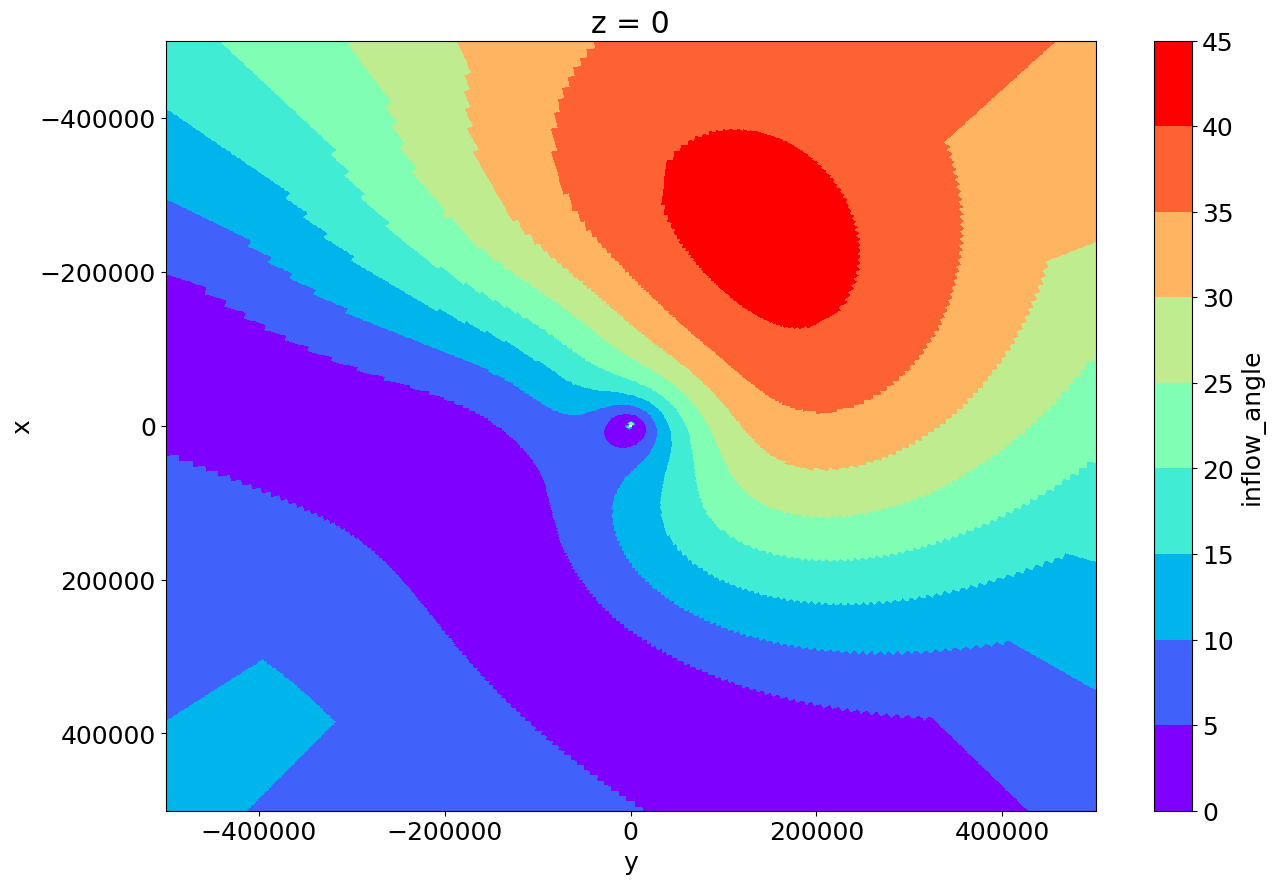

In [7]:
# Tamizi 2020 Fig. 16 (comparer aussi avec leur Fig. 14 quand j'ajoute Ut)
abs(kep_car.sel(z=0).inflow_angle).plot(vmin=0, vmax=45, cmap=cm.get_cmap('rainbow', 9))
plt.gca().invert_yaxis() # Cette ligne fait que le cyclone va vers le haut de la page

### Check Kepert at the surface (z = 0)

/tmp/ipykernel_52228/103320810.py:6: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for line, lvl in zip(cntr.collections, cntr.levels):


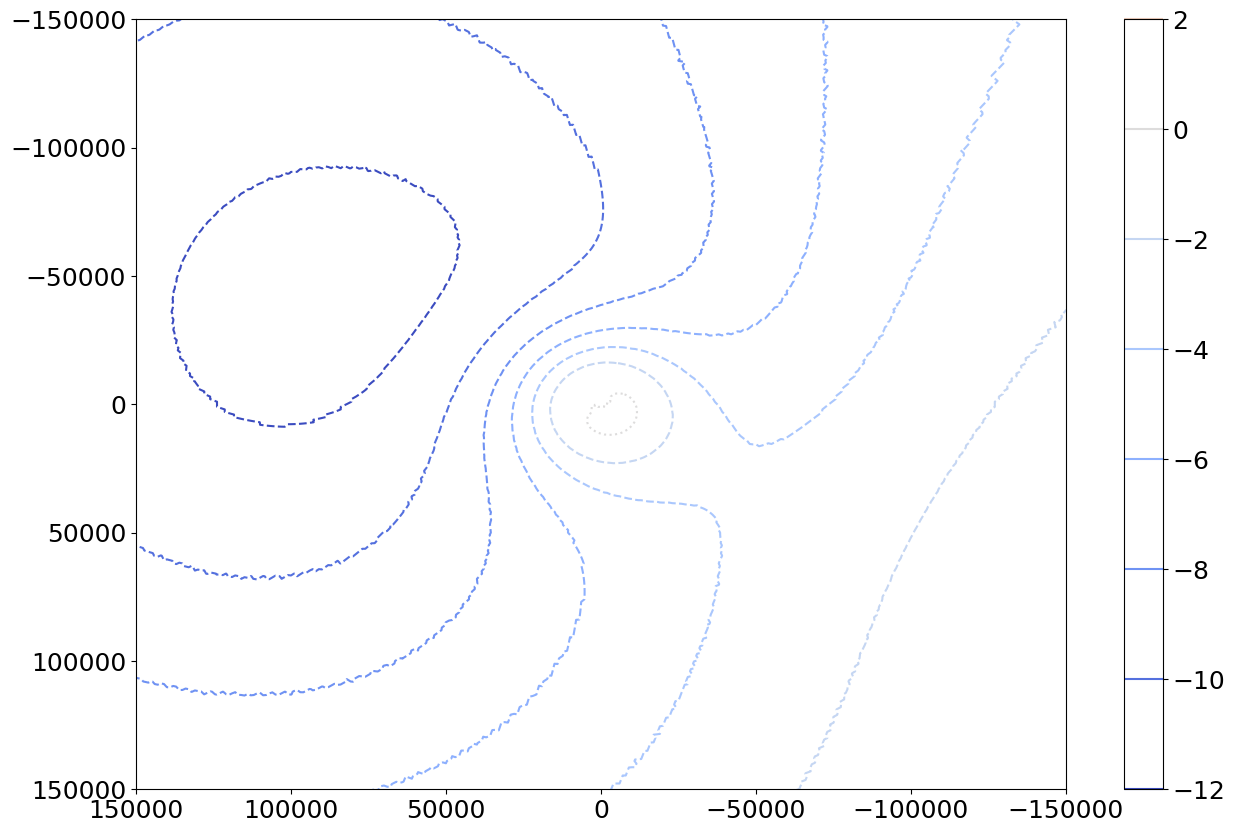

In [8]:
# 5th column (storm-relative radial flow)

cntr = plt.contour(x_ref, y_ref, np.array(kep_car.sel(z=0).rad_wind), levels=[-12, -10, -8, -6, -4, -2, 0, 2], vmin=-12, vmax=12, cmap='coolwarm')

# Override the linestyles based on the levels.
for line, lvl in zip(cntr.collections, cntr.levels):
    if lvl < 0:
        line.set_linestyle('--')
    elif lvl == 0:
        line.set_linestyle(':')
    else:
        line.set_linestyle('-')

# Grid
plt.colorbar()
plt.xlim(-150000, 150000)
plt.ylim(-150000, 150000)

# Pour se ramener à Kepert on tourne a figure de 180° (pas très élégant comme solution mais bon):
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

/tmp/ipykernel_52228/3378553589.py:7: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for line, lvl in zip(cntr.collections, cntr.levels):


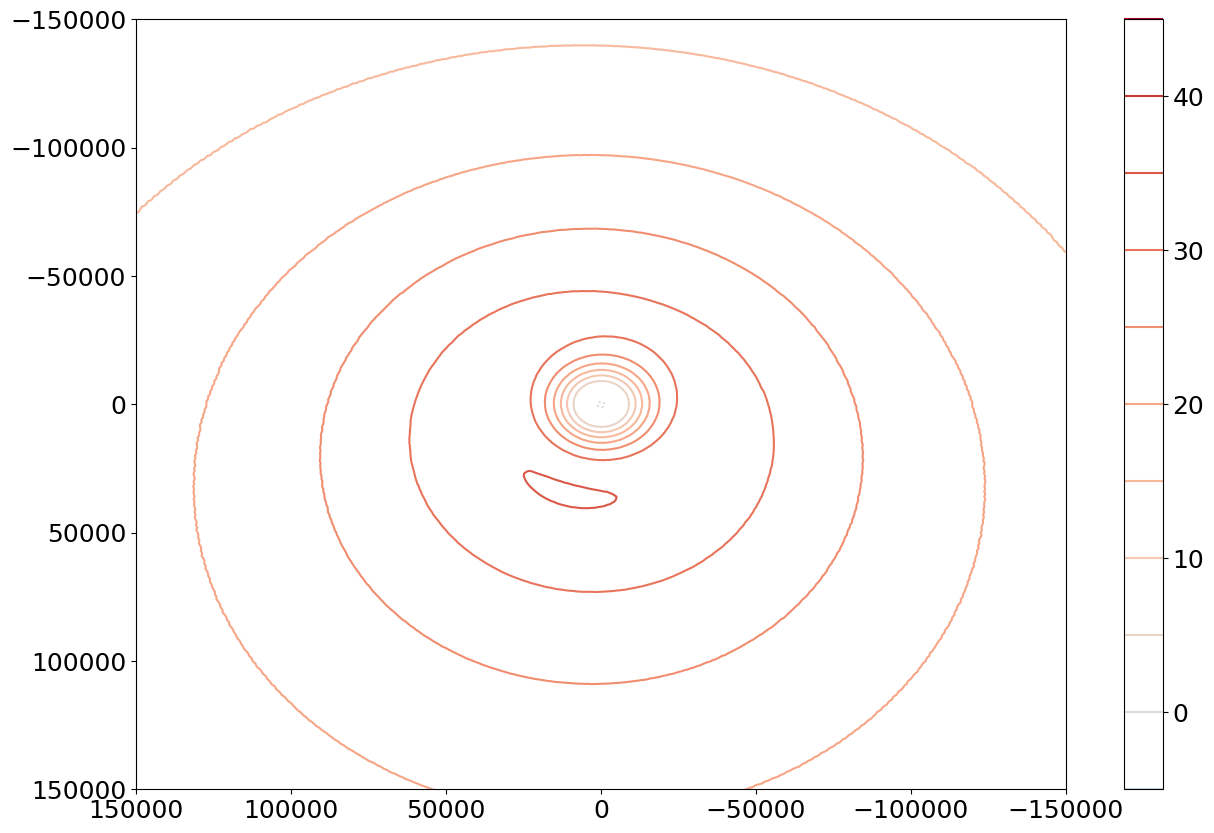

In [9]:
# 6th column (storm-relative azimuthal flow)

cntr = plt.contour(x_ref, y_ref, np.array(kep_car.sel(z=0).tan_wind), levels=[-5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45], vmin=-45, vmax=45, cmap='coolwarm')


# Override the linestyles based on the levels.
for line, lvl in zip(cntr.collections, cntr.levels):
    if lvl < 0:
        line.set_linestyle('--')
    elif lvl == 0:
        line.set_linestyle(':')
    else:
        line.set_linestyle('-')

# Grid
plt.colorbar()
plt.xlim(-150000, 150000)
plt.ylim(-150000, 150000)

# Pour se ramener à Kepert on tourne a figure de 180° (pas très élégant comme solution mais bon):
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

In [10]:
def get_asymmetric_components_kepert2001(THs, Rs, Vs, Ut, K, C, fcor, z):
    u_1_K01 = u_1(THs, Rs, Vs, Ut, K, C, fcor, z)
    v_1_K01 = v_1(THs, Rs, Vs, Ut, K, C, fcor, z)
    u1_K01  = u1(THs, Rs, Vs, Ut, K, C, fcor, z)
    v1_K01  = v1(THs, Rs, Vs, Ut, K, C, fcor, z)
    return u_1_K01, v_1_K01, u1_K01, v1_K01

u_1_K01, v_1_K01, u1_K01, v1_K01 = get_asymmetric_components_kepert2001(THs, Rs, Vs, Ut, K, C, fcr, z=0)

a_pol = xr.Dataset(
    data_vars={
        'u_1': (('theta', 'rad'), u_1_K01),
        'v_1': (('theta', 'rad'), v_1_K01),
        'u1':  (('theta', 'rad'), u1_K01),
        'v1':  (('theta', 'rad'), v1_K01),
    },
    coords={
        'theta': np.rad2deg(ths),
        'rad': rs,
    }
)

a_car = xr.Dataset(
    data_vars={
        'u_1': (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(a_pol.u_1).flatten(), (x_ref, y_ref), method='nearest')),
        'v_1': (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(a_pol.v_1).flatten(), (x_ref, y_ref), method='nearest')),
        'u1':  (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(a_pol.u1).flatten(),  (x_ref, y_ref), method='nearest')),
        'v1':  (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(a_pol.v1).flatten(),  (x_ref, y_ref), method='nearest')),
    },
    coords={
        'x': dim_ref,
        'y': dim_ref,
    }
)

/tmp/ipykernel_52228/436064675.py:6: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for line, lvl in zip(cntr.collections, cntr.levels):


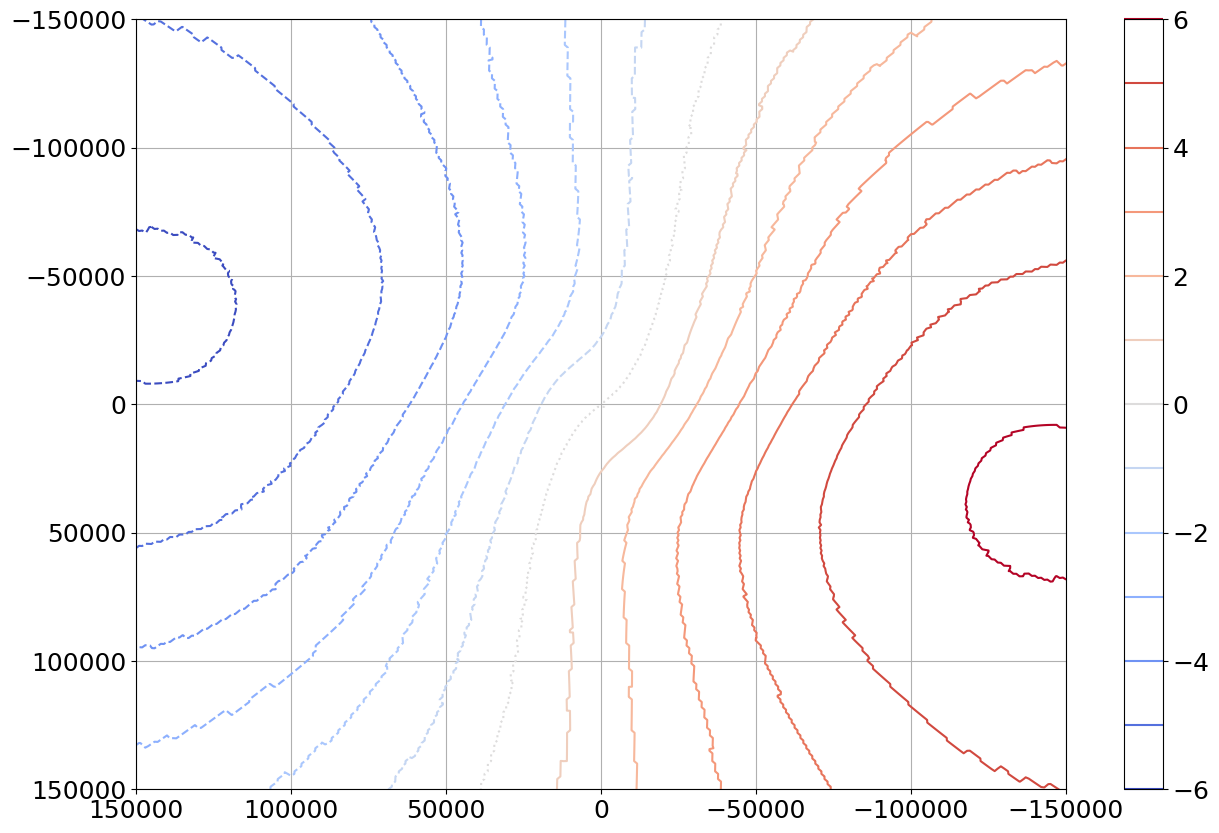

In [11]:
# 1st column (u-1) - OK

cntr = plt.contour(x_ref, y_ref, np.array(a_car.u_1), levels=[-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6], vmin=-6, vmax=6, cmap='coolwarm')

# Override the linestyles based on the levels.
for line, lvl in zip(cntr.collections, cntr.levels):
    if lvl < 0:
        line.set_linestyle('--')
    elif lvl == 0:
        line.set_linestyle(':')
    else:
        line.set_linestyle('-')

# Grid
plt.colorbar()
plt.xlim(-150000, 150000)
plt.ylim(-150000, 150000)
plt.grid()

# Pour se ramener à Kepert on tourne a figure de 180° (pas très élégant comme solution mais bon):
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

/tmp/ipykernel_52228/3852200409.py:6: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for line, lvl in zip(cntr.collections, cntr.levels):


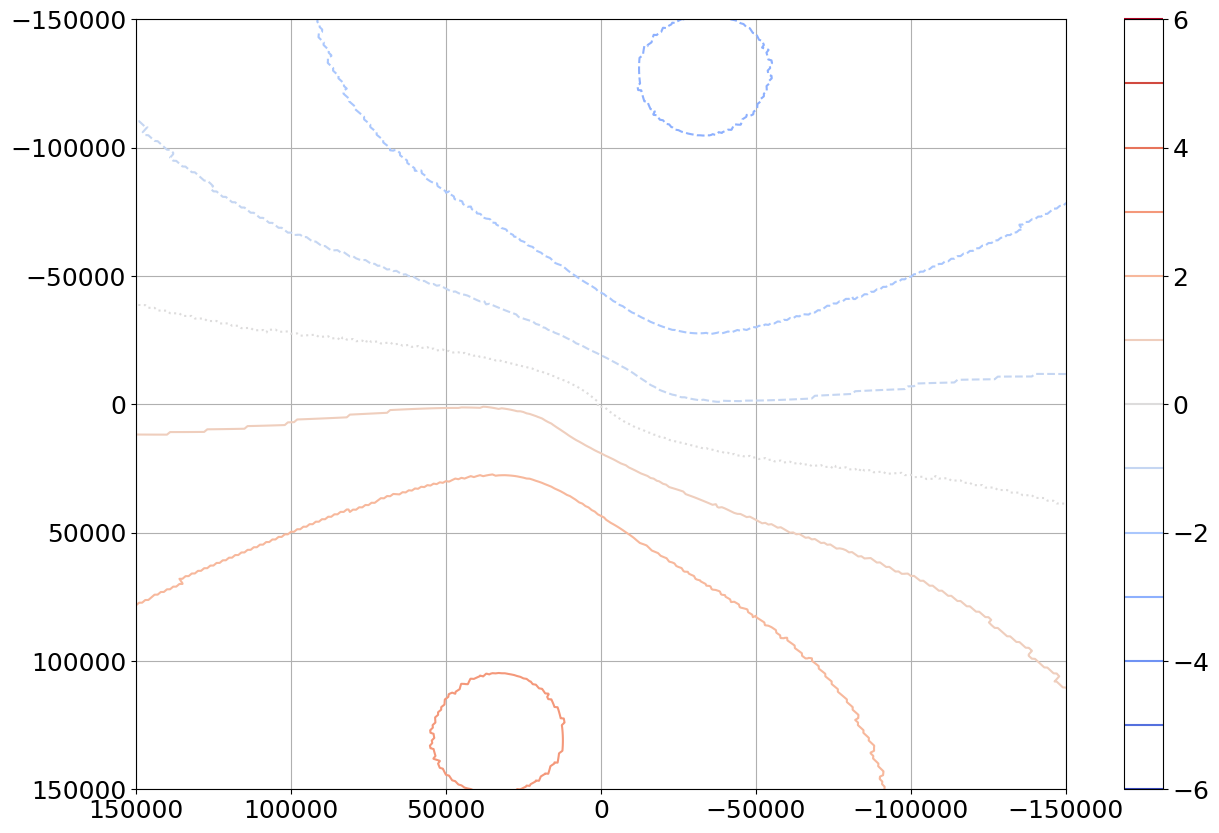

In [12]:
# 2nd column (v-1) - OK

cntr = plt.contour(x_ref, y_ref, np.array(a_car.v_1), levels=[-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6], vmin=-6, vmax=6, cmap='coolwarm')

# Override the linestyles based on the levels.
for line, lvl in zip(cntr.collections, cntr.levels):
    if lvl < 0:
        line.set_linestyle('--')
    elif lvl == 0:
        line.set_linestyle(':')
    else:
        line.set_linestyle('-')

# Grid
plt.colorbar()
plt.xlim(-150000, 150000)
plt.ylim(-150000, 150000)
plt.grid()

# Pour se ramener à Kepert on tourne a figure de 180° (pas très élégant comme solution mais bon):
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

/tmp/ipykernel_52228/2612076923.py:6: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for line, lvl in zip(cntr.collections, cntr.levels):


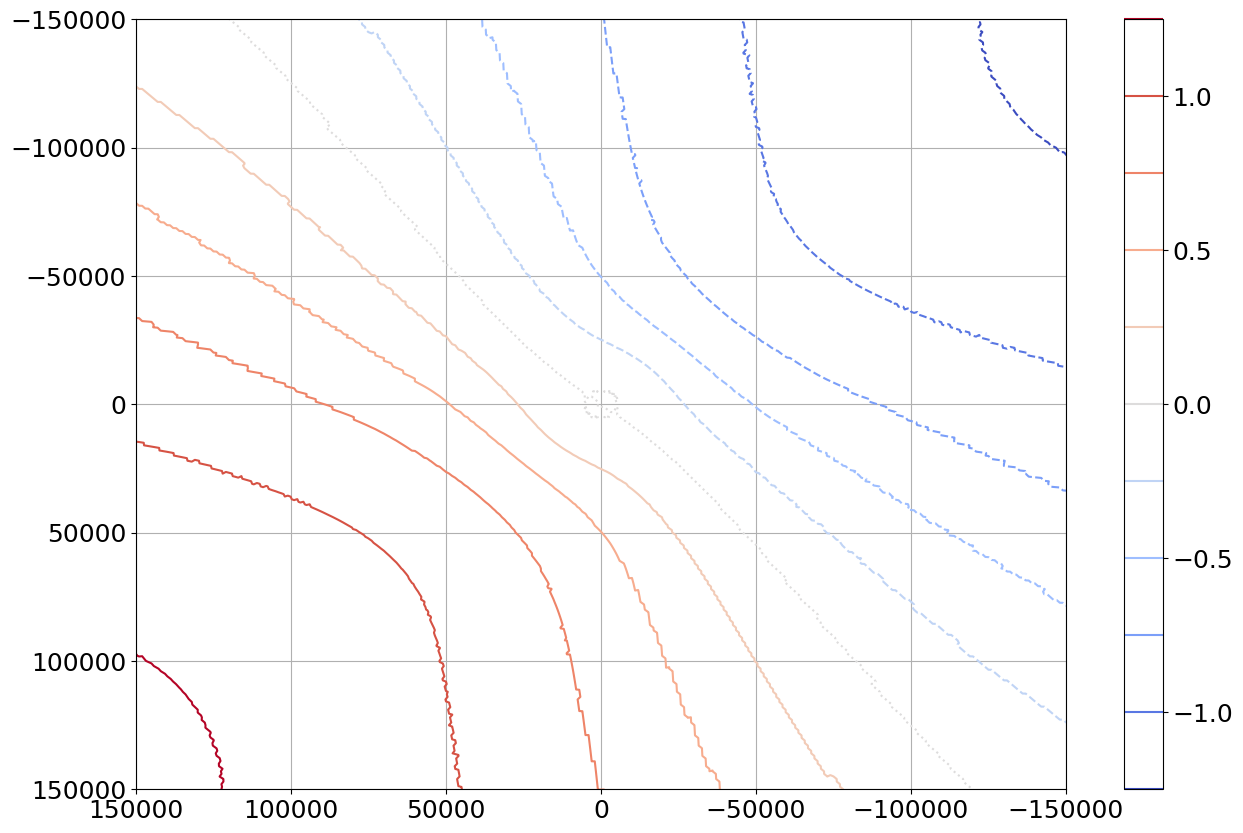

In [13]:
# 3rd column (u1) - OK

cntr = plt.contour(x_ref, y_ref, np.array(a_car.u1), levels=[-1.25, -1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 1.25],  vmin=-1.25, vmax=1.25, cmap='coolwarm')

# Override the linestyles based on the levels.
for line, lvl in zip(cntr.collections, cntr.levels):
    if lvl < 0:
        line.set_linestyle('--')
    elif lvl == 0:
        line.set_linestyle(':')
    else:
        line.set_linestyle('-')

# Grid
plt.colorbar()
plt.xlim(-150000, 150000)
plt.ylim(-150000, 150000)
plt.grid()

# Pour se ramener à Kepert on tourne a figure de 180° (pas très élégant comme solution mais bon):
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

/tmp/ipykernel_52228/2264685193.py:6: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for line, lvl in zip(cntr.collections, cntr.levels):


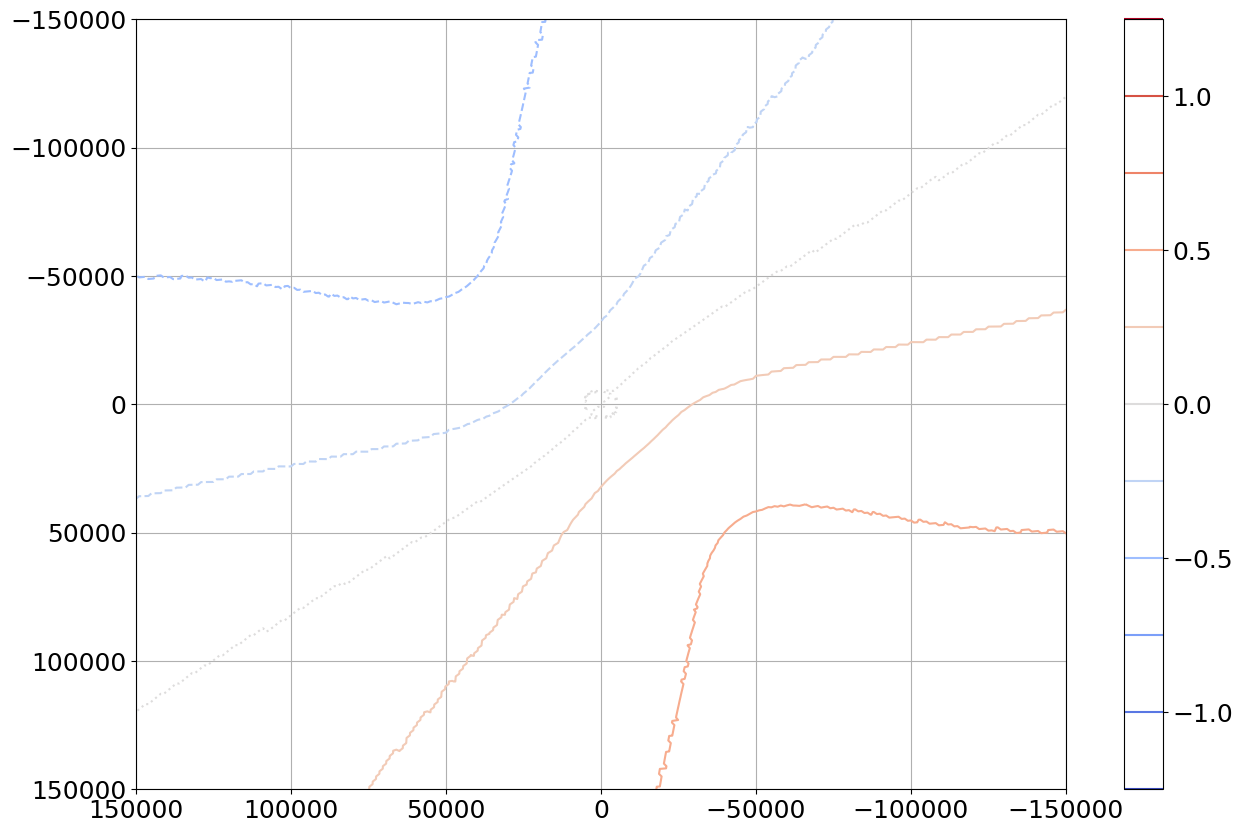

In [14]:
# 4th column (v1) - OK

cntr = plt.contour(x_ref, y_ref, np.array(a_car.v1), levels=[-1.25, -1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 1.25], vmin=-1.25, vmax=1.25, cmap='coolwarm')

# Override the linestyles based on the levels.
for line, lvl in zip(cntr.collections, cntr.levels):
    if lvl < 0:
        line.set_linestyle('--')
    elif lvl == 0:
        line.set_linestyle(':')
    else:
        line.set_linestyle('-')

# Grid
plt.colorbar()
plt.xlim(-150000, 150000)
plt.ylim(-150000, 150000)
plt.grid()

# Pour se ramener à Kepert on tourne a figure de 180° (pas très élégant comme solution mais bon):
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

In [15]:
### Own checks
def get_symmetric_components_kepert2001(Rs, Vs, K, C, fcor, z):
    u0_K01 = u0(Rs, Vs, K, C, fcor, z)
    v0_K01 = v0(Rs, Vs, K, C, fcor, z)
    return u0_K01, v0_K01

u0_K01, v0_K01 = get_symmetric_components_kepert2001(Rs, Vs, K, C, fcr, z=0)

a_pol = xr.Dataset(
    data_vars={
        'u0': (('theta', 'rad'), u0_K01),
        'v0': (('theta', 'rad'), v0_K01),
    },
    coords={
        'theta': np.rad2deg(ths),
        'rad': rs,
    }
)

a_car = xr.Dataset(
    data_vars={
        'u0': (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(a_pol.u0).flatten(), (x_ref, y_ref), method='nearest')),
        'v0': (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(a_pol.v0).flatten(), (x_ref, y_ref), method='nearest')),
    },
    coords={
        'x': dim_ref,
        'y': dim_ref,
    }
)

/tmp/ipykernel_52228/513060175.py:6: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for line, lvl in zip(cntr.collections, cntr.levels):


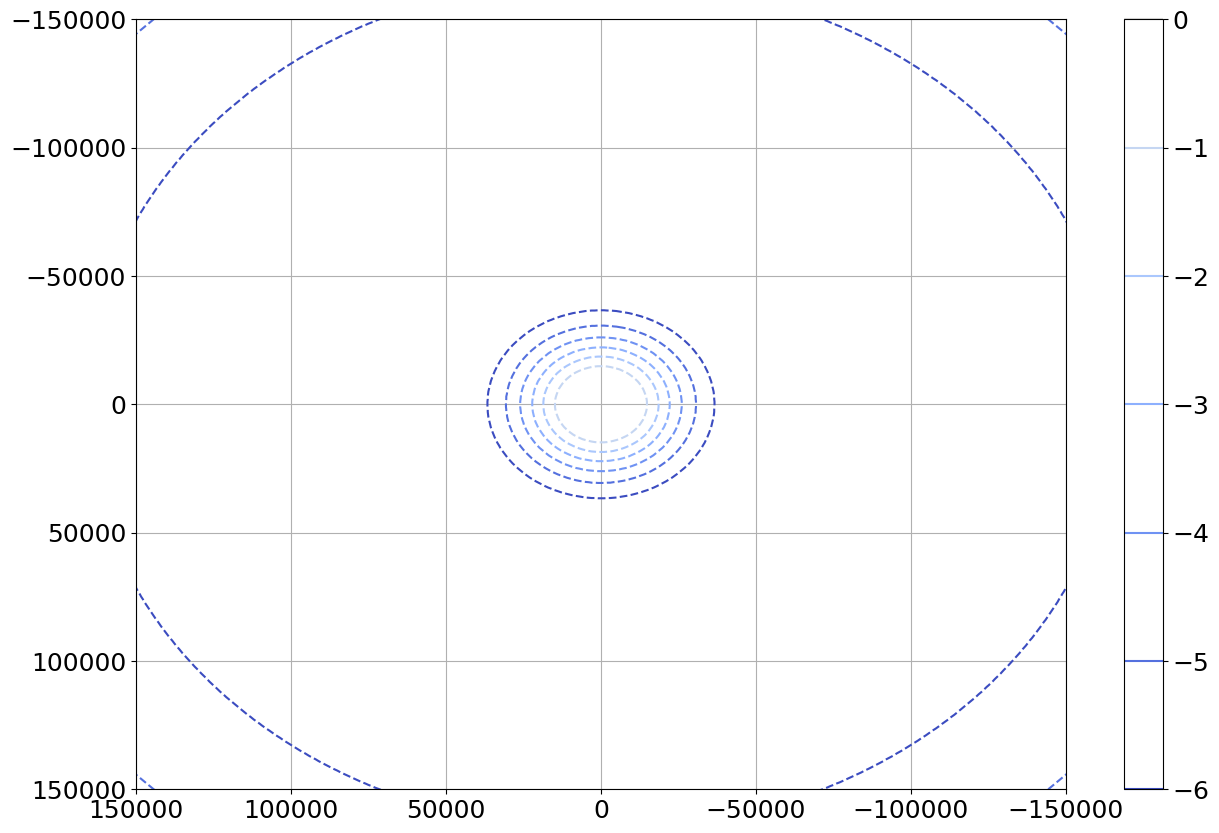

In [16]:
# Custom (u0)

cntr = plt.contour(x_ref, y_ref, np.array(a_car.u0), levels=[-6, -5, -4, -3, -2, -1, 0], vmin=-6, vmax=6, cmap='coolwarm')

# Override the linestyles based on the levels.
for line, lvl in zip(cntr.collections, cntr.levels):
    if lvl < 0:
        line.set_linestyle('--')
    elif lvl == 0:
        line.set_linestyle(':')
    else:
        line.set_linestyle('-')

# Grid
plt.colorbar()
plt.xlim(-150000, 150000)
plt.ylim(-150000, 150000)
plt.grid()

# Pour se ramener à Kepert on tourne a figure de 180° (pas très élégant comme solution mais bon):
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

/tmp/ipykernel_52228/3887339507.py:6: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for line, lvl in zip(cntr.collections, cntr.levels):


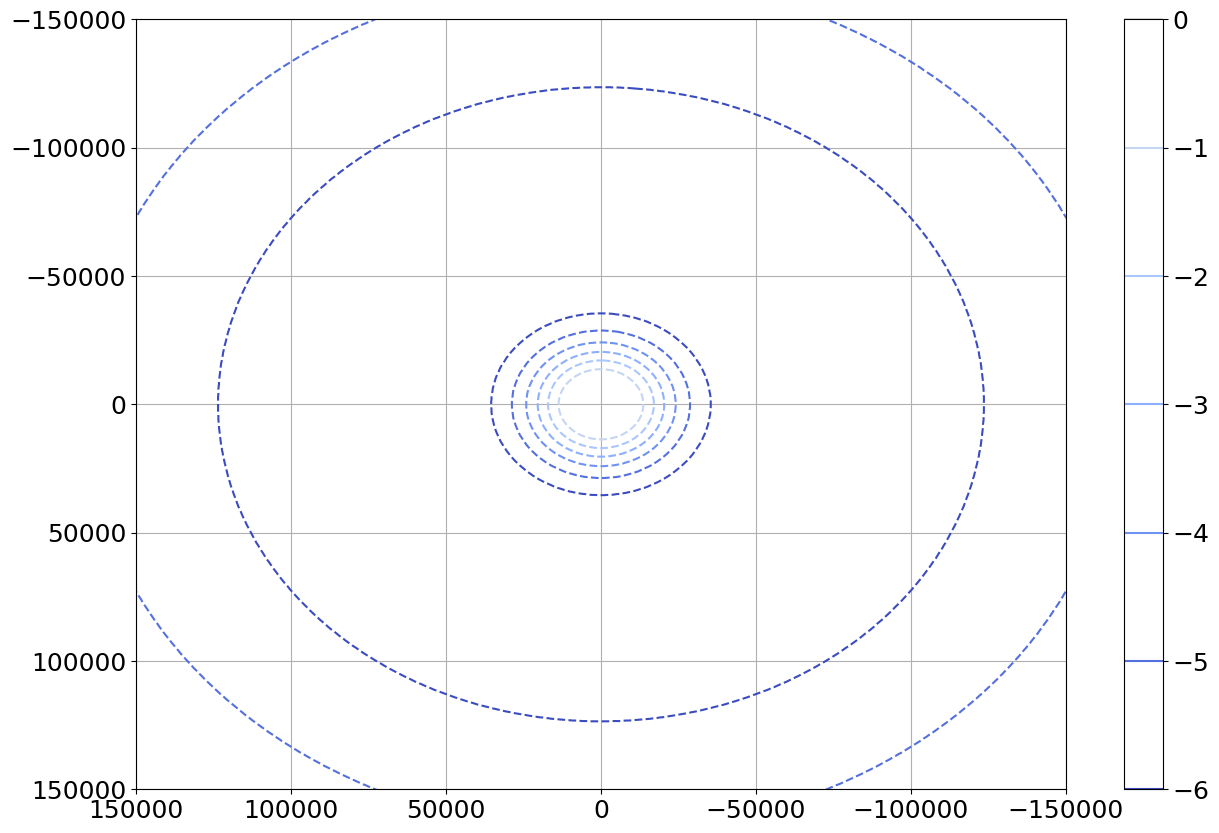

In [17]:
# Custom (v0)

cntr = plt.contour(x_ref, y_ref, np.array(a_car.v0), levels=[-6, -5, -4, -3, -2, -1, 0], vmin=-6, vmax=6, cmap='coolwarm')

# Override the linestyles based on the levels.
for line, lvl in zip(cntr.collections, cntr.levels):
    if lvl < 0:
        line.set_linestyle('--')
    elif lvl == 0:
        line.set_linestyle(':')
    else:
        line.set_linestyle('-')

# Grid
plt.colorbar()
plt.xlim(-150000, 150000)
plt.ylim(-150000, 150000)
plt.grid()

# Pour se ramener à Kepert on tourne a figure de 180° (pas très élégant comme solution mais bon):
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

### At z=500m

/tmp/ipykernel_52228/3334505431.py:6: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for line, lvl in zip(cntr.collections, cntr.levels):


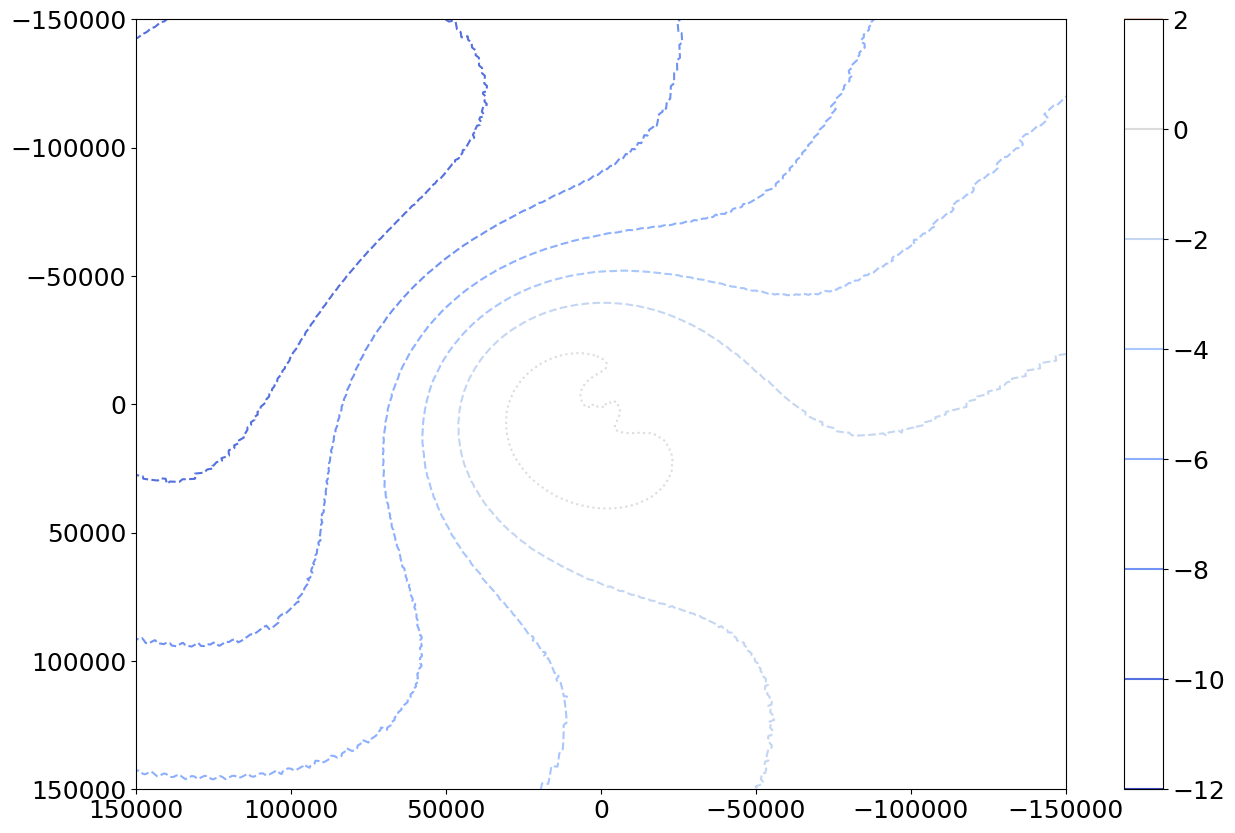

In [18]:
# 5th column (storm-relative radial flow)

cntr = plt.contour(x_ref, y_ref, np.array(kep_car.sel(z=500).rad_wind), levels=[-12, -10, -8, -6, -4, -2, 0, 2], vmin=-12, vmax=12, cmap='coolwarm')

# Override the linestyles based on the levels.
for line, lvl in zip(cntr.collections, cntr.levels):
    if lvl < 0:
        line.set_linestyle('--')
    elif lvl == 0:
        line.set_linestyle(':')
    else:
        line.set_linestyle('-')

# Grid
plt.colorbar()
plt.xlim(-150000, 150000)
plt.ylim(-150000, 150000)

# Pour se ramener à Kepert on tourne a figure de 180° (pas très élégant comme solution mais bon):
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

/tmp/ipykernel_52228/3296226229.py:7: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for line, lvl in zip(cntr.collections, cntr.levels):


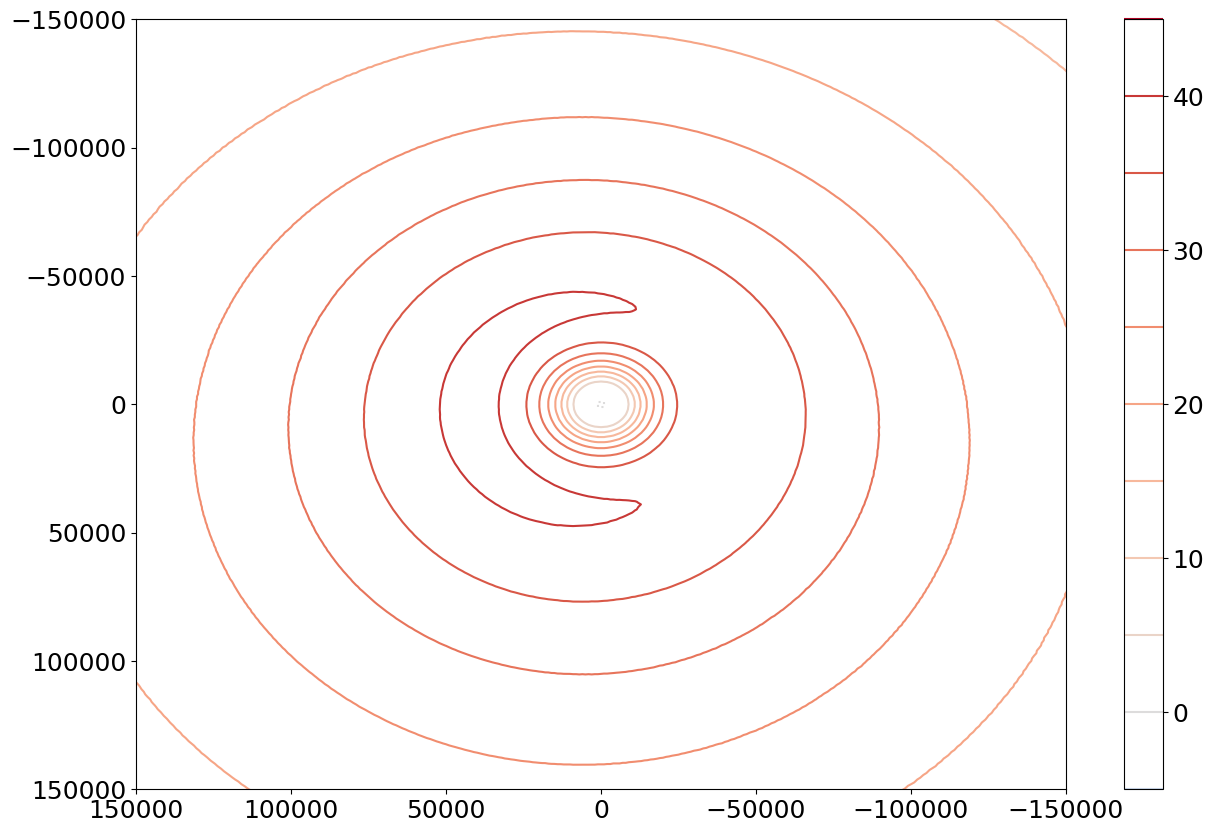

In [19]:
# 6th column (storm-relative azimuthal flow)

cntr = plt.contour(x_ref, y_ref, np.array(kep_car.sel(z=500).tan_wind), levels=[-5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45], vmin=-45, vmax=45, cmap='coolwarm')


# Override the linestyles based on the levels.
for line, lvl in zip(cntr.collections, cntr.levels):
    if lvl < 0:
        line.set_linestyle('--')
    elif lvl == 0:
        line.set_linestyle(':')
    else:
        line.set_linestyle('-')

# Grid
plt.colorbar()
plt.xlim(-150000, 150000)
plt.ylim(-150000, 150000)

# Pour se ramener à Kepert on tourne a figure de 180° (pas très élégant comme solution mais bon):
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

In [20]:
u_1_K01, v_1_K01, u1_K01, v1_K01 = get_asymmetric_components_kepert2001(THs, Rs, Vs, Ut, K, C, fcr, z=500)

a_pol = xr.Dataset(
    data_vars={
        'u_1': (('theta', 'rad'), u_1_K01),
        'v_1': (('theta', 'rad'), v_1_K01),
        'u1':  (('theta', 'rad'), u1_K01),
        'v1':  (('theta', 'rad'), v1_K01),
    },
    coords={
        'theta': np.rad2deg(ths),
        'rad': rs,
    }
)

a_car = xr.Dataset(
    data_vars={
        'u_1': (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(a_pol.u_1).flatten(), (x_ref, y_ref), method='nearest')),
        'v_1': (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(a_pol.v_1).flatten(), (x_ref, y_ref), method='nearest')),
        'u1':  (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(a_pol.u1).flatten(),  (x_ref, y_ref), method='nearest')),
        'v1':  (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(a_pol.v1).flatten(),  (x_ref, y_ref), method='nearest')),
    },
    coords={
        'x': dim_ref,
        'y': dim_ref,
    }
)

/tmp/ipykernel_52228/436064675.py:6: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for line, lvl in zip(cntr.collections, cntr.levels):


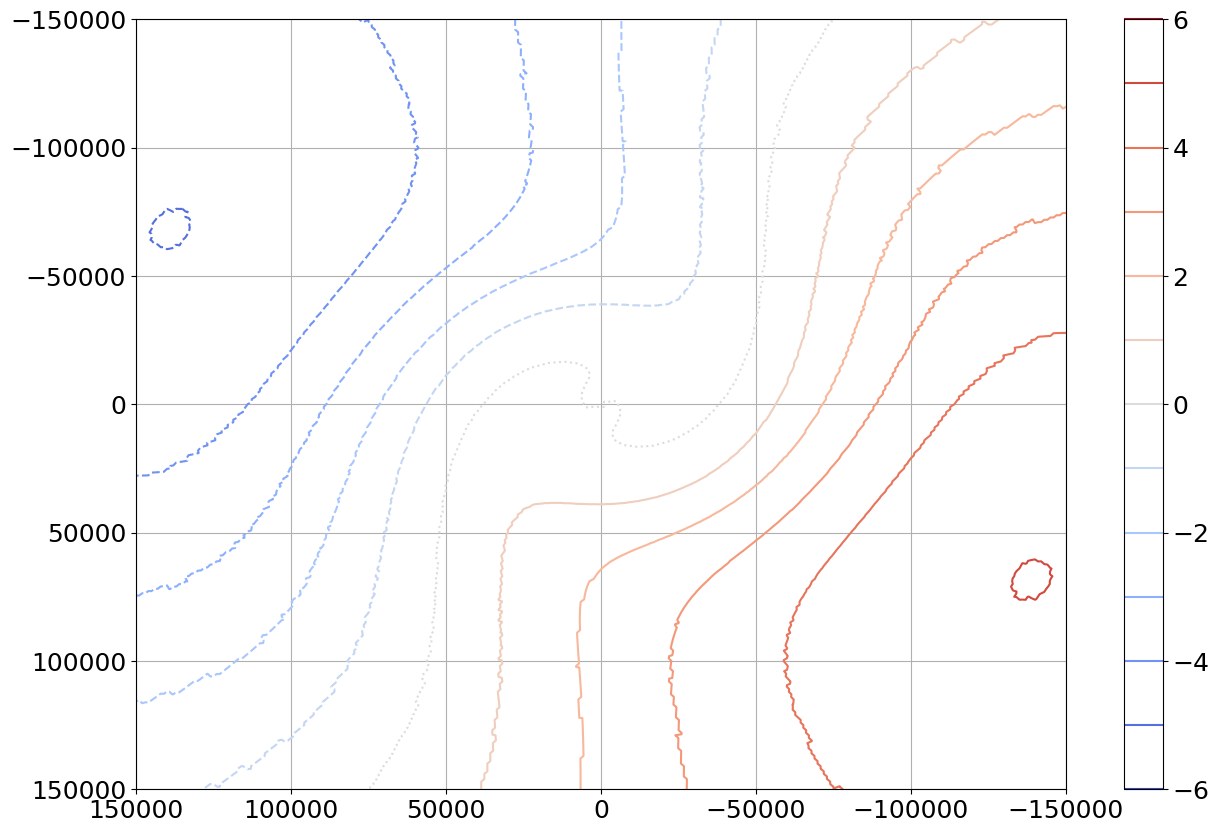

In [21]:
# 1st column (u-1) - OK

cntr = plt.contour(x_ref, y_ref, np.array(a_car.u_1), levels=[-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6], vmin=-6, vmax=6, cmap='coolwarm')

# Override the linestyles based on the levels.
for line, lvl in zip(cntr.collections, cntr.levels):
    if lvl < 0:
        line.set_linestyle('--')
    elif lvl == 0:
        line.set_linestyle(':')
    else:
        line.set_linestyle('-')

# Grid
plt.colorbar()
plt.xlim(-150000, 150000)
plt.ylim(-150000, 150000)
plt.grid()

# Pour se ramener à Kepert on tourne a figure de 180° (pas très élégant comme solution mais bon):
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

/tmp/ipykernel_52228/3852200409.py:6: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for line, lvl in zip(cntr.collections, cntr.levels):


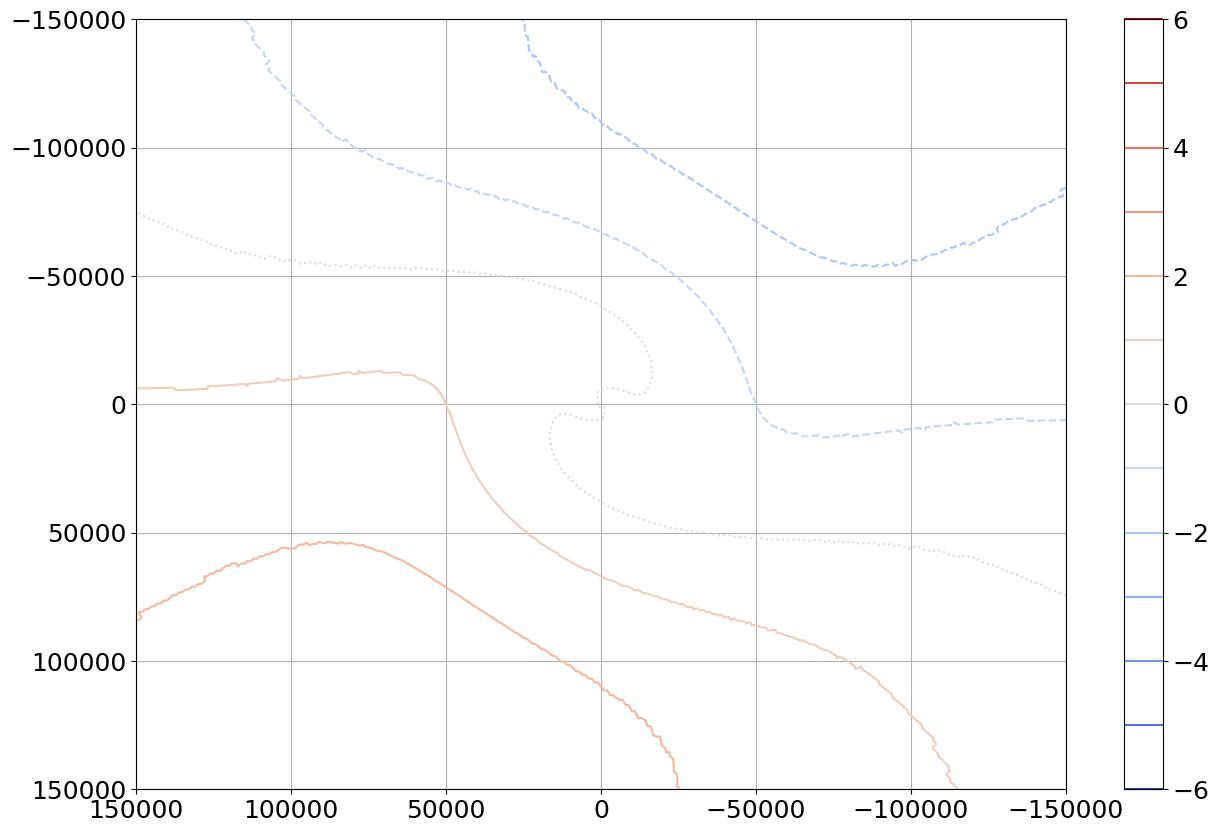

In [22]:
# 2nd column (v-1) - OK

cntr = plt.contour(x_ref, y_ref, np.array(a_car.v_1), levels=[-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6], vmin=-6, vmax=6, cmap='coolwarm')

# Override the linestyles based on the levels.
for line, lvl in zip(cntr.collections, cntr.levels):
    if lvl < 0:
        line.set_linestyle('--')
    elif lvl == 0:
        line.set_linestyle(':')
    else:
        line.set_linestyle('-')

# Grid
plt.colorbar()
plt.xlim(-150000, 150000)
plt.ylim(-150000, 150000)
plt.grid()

# Pour se ramener à Kepert on tourne a figure de 180° (pas très élégant comme solution mais bon):
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

/tmp/ipykernel_52228/2612076923.py:6: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for line, lvl in zip(cntr.collections, cntr.levels):


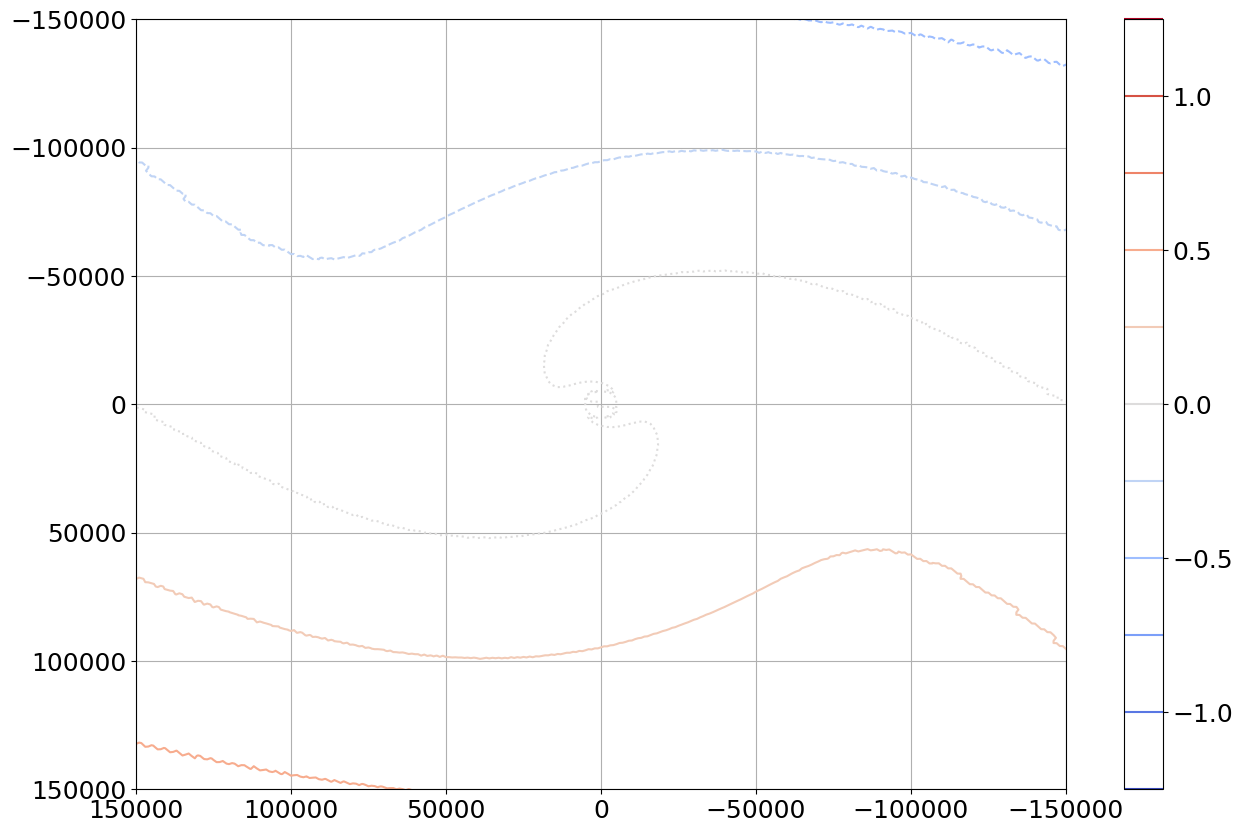

In [23]:
# 3rd column (u1) - OK

cntr = plt.contour(x_ref, y_ref, np.array(a_car.u1), levels=[-1.25, -1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 1.25],  vmin=-1.25, vmax=1.25, cmap='coolwarm')

# Override the linestyles based on the levels.
for line, lvl in zip(cntr.collections, cntr.levels):
    if lvl < 0:
        line.set_linestyle('--')
    elif lvl == 0:
        line.set_linestyle(':')
    else:
        line.set_linestyle('-')

# Grid
plt.colorbar()
plt.xlim(-150000, 150000)
plt.ylim(-150000, 150000)
plt.grid()

# Pour se ramener à Kepert on tourne a figure de 180° (pas très élégant comme solution mais bon):
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

/tmp/ipykernel_52228/2264685193.py:6: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for line, lvl in zip(cntr.collections, cntr.levels):


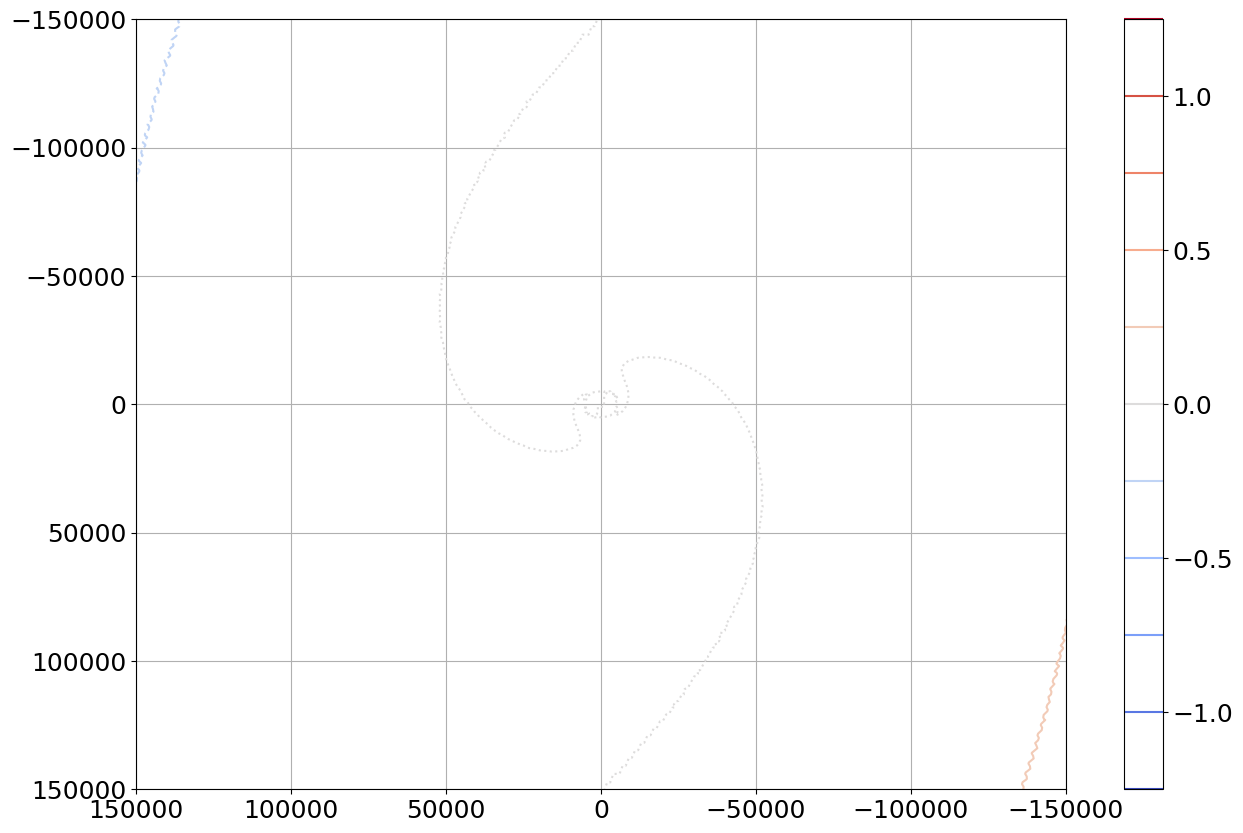

In [24]:
# 4th column (v1) - OK

cntr = plt.contour(x_ref, y_ref, np.array(a_car.v1), levels=[-1.25, -1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 1.25], vmin=-1.25, vmax=1.25, cmap='coolwarm')

# Override the linestyles based on the levels.
for line, lvl in zip(cntr.collections, cntr.levels):
    if lvl < 0:
        line.set_linestyle('--')
    elif lvl == 0:
        line.set_linestyle(':')
    else:
        line.set_linestyle('-')

# Grid
plt.colorbar()
plt.xlim(-150000, 150000)
plt.ylim(-150000, 150000)
plt.grid()

# Pour se ramener à Kepert on tourne a figure de 180° (pas très élégant comme solution mais bon):
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

### At z=1000m

/tmp/ipykernel_52228/1377189684.py:6: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for line, lvl in zip(cntr.collections, cntr.levels):


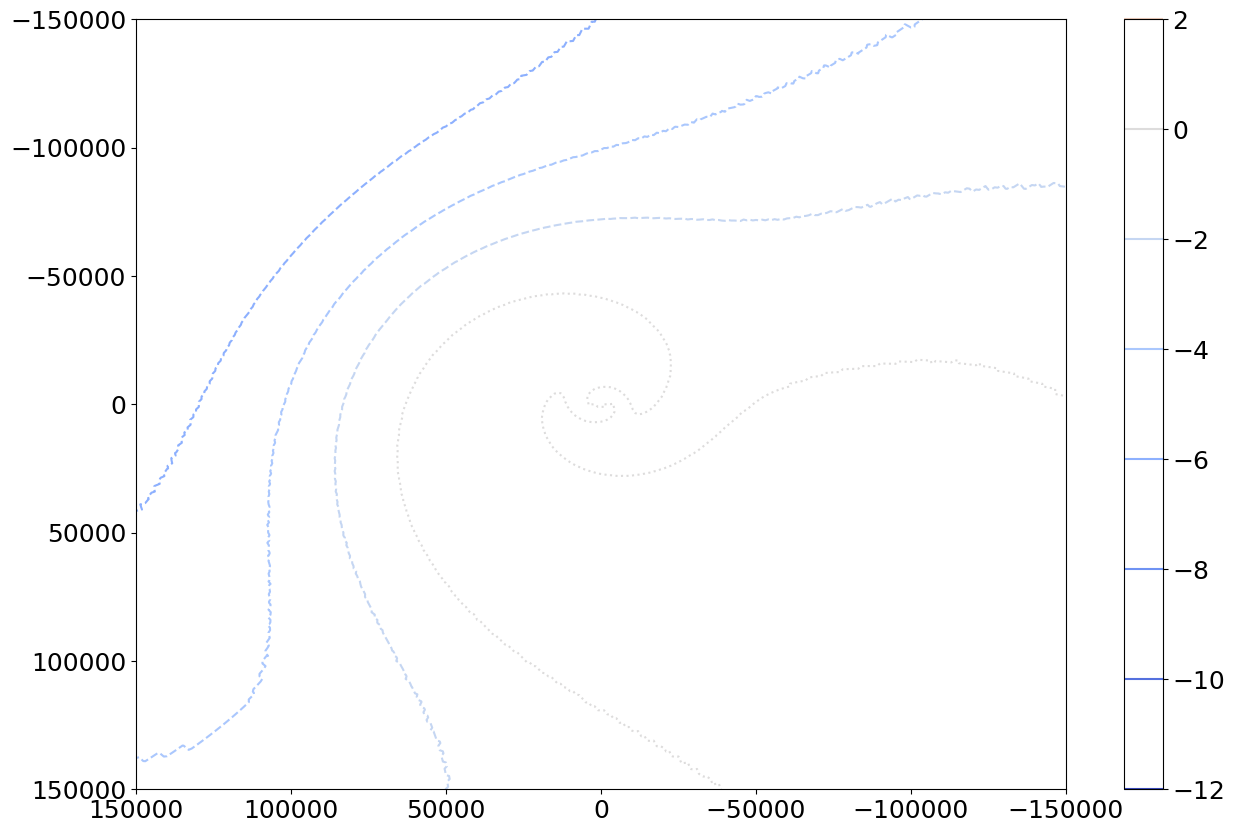

In [25]:
# 5th column (storm-relative radial flow)

cntr = plt.contour(x_ref, y_ref, np.array(kep_car.sel(z=1000).rad_wind), levels=[-12, -10, -8, -6, -4, -2, 0, 2], vmin=-12, vmax=12, cmap='coolwarm')

# Override the linestyles based on the levels.
for line, lvl in zip(cntr.collections, cntr.levels):
    if lvl < 0:
        line.set_linestyle('--')
    elif lvl == 0:
        line.set_linestyle(':')
    else:
        line.set_linestyle('-')

# Grid
plt.colorbar()
plt.xlim(-150000, 150000)
plt.ylim(-150000, 150000)

# Pour se ramener à Kepert on tourne a figure de 180° (pas très élégant comme solution mais bon):
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

/tmp/ipykernel_52228/2320245547.py:7: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for line, lvl in zip(cntr.collections, cntr.levels):


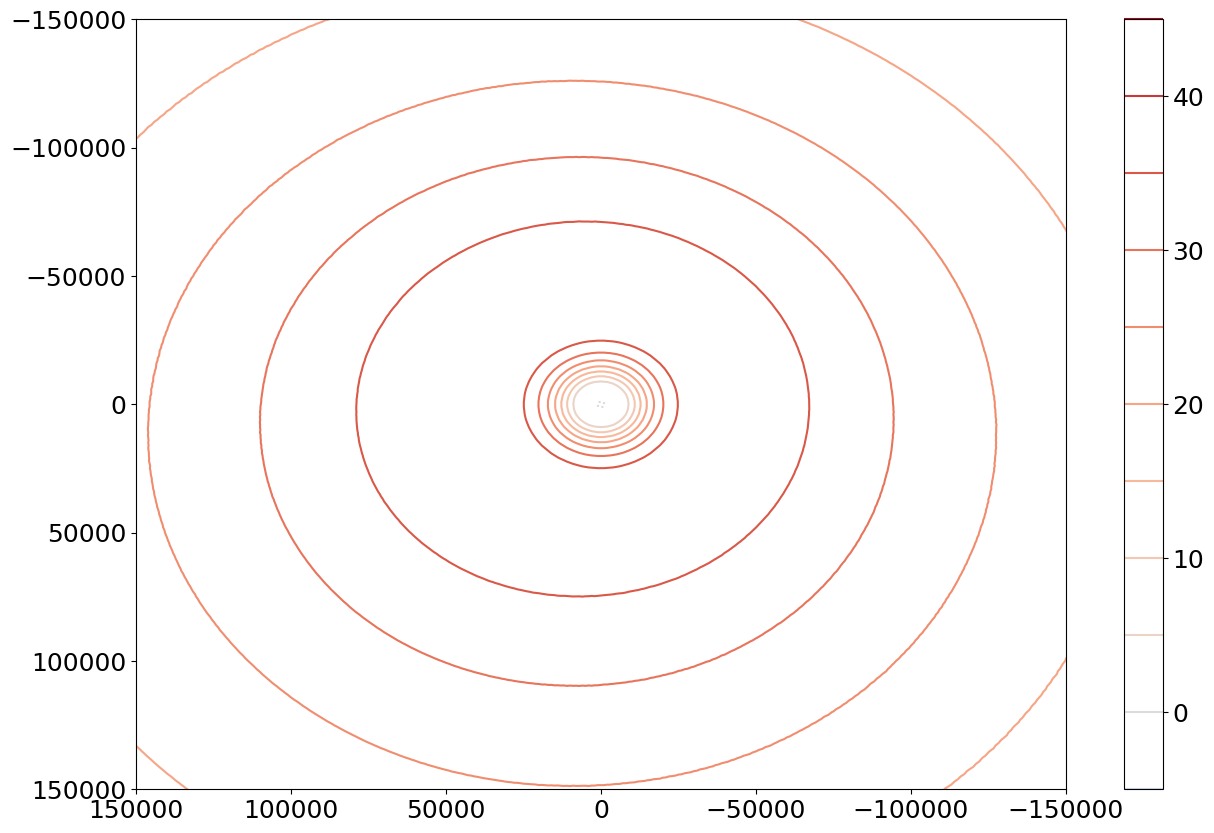

In [26]:
# 6th column (storm-relative azimuthal flow)

cntr = plt.contour(x_ref, y_ref, np.array(kep_car.sel(z=1000).tan_wind), levels=[-5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45], vmin=-45, vmax=45, cmap='coolwarm')


# Override the linestyles based on the levels.
for line, lvl in zip(cntr.collections, cntr.levels):
    if lvl < 0:
        line.set_linestyle('--')
    elif lvl == 0:
        line.set_linestyle(':')
    else:
        line.set_linestyle('-')

# Grid
plt.colorbar()
plt.xlim(-150000, 150000)
plt.ylim(-150000, 150000)

# Pour se ramener à Kepert on tourne a figure de 180° (pas très élégant comme solution mais bon):
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

In [27]:
u_1_K01, v_1_K01, u1_K01, v1_K01 = get_asymmetric_components_kepert2001(THs, Rs, Vs, Ut, K, C, fcr, z=1000)

a_pol = xr.Dataset(
    data_vars={
        'u_1': (('theta', 'rad'), u_1_K01),
        'v_1': (('theta', 'rad'), v_1_K01),
        'u1':  (('theta', 'rad'), u1_K01),
        'v1':  (('theta', 'rad'), v1_K01),
    },
    coords={
        'theta': np.rad2deg(ths),
        'rad': rs,
    }
)

a_car = xr.Dataset(
    data_vars={
        'u_1': (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(a_pol.u_1).flatten(), (x_ref, y_ref), method='nearest')),
        'v_1': (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(a_pol.v_1).flatten(), (x_ref, y_ref), method='nearest')),
        'u1':  (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(a_pol.u1).flatten(),  (x_ref, y_ref), method='nearest')),
        'v1':  (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(a_pol.v1).flatten(),  (x_ref, y_ref), method='nearest')),
    },
    coords={
        'x': dim_ref,
        'y': dim_ref,
    }
)

/tmp/ipykernel_52228/436064675.py:6: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for line, lvl in zip(cntr.collections, cntr.levels):


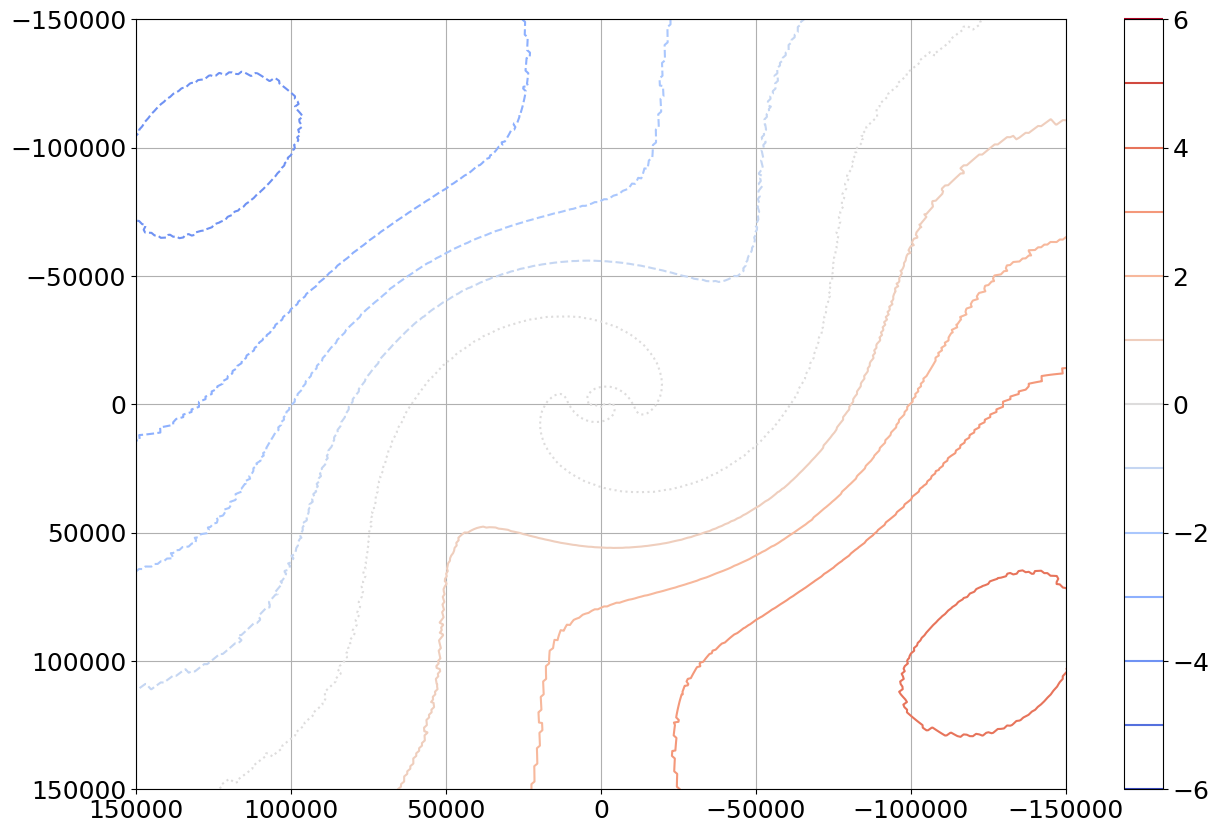

In [28]:
# 1st column (u-1) - OK

cntr = plt.contour(x_ref, y_ref, np.array(a_car.u_1), levels=[-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6], vmin=-6, vmax=6, cmap='coolwarm')

# Override the linestyles based on the levels.
for line, lvl in zip(cntr.collections, cntr.levels):
    if lvl < 0:
        line.set_linestyle('--')
    elif lvl == 0:
        line.set_linestyle(':')
    else:
        line.set_linestyle('-')

# Grid
plt.colorbar()
plt.xlim(-150000, 150000)
plt.ylim(-150000, 150000)
plt.grid()

# Pour se ramener à Kepert on tourne a figure de 180° (pas très élégant comme solution mais bon):
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

/tmp/ipykernel_52228/3852200409.py:6: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for line, lvl in zip(cntr.collections, cntr.levels):


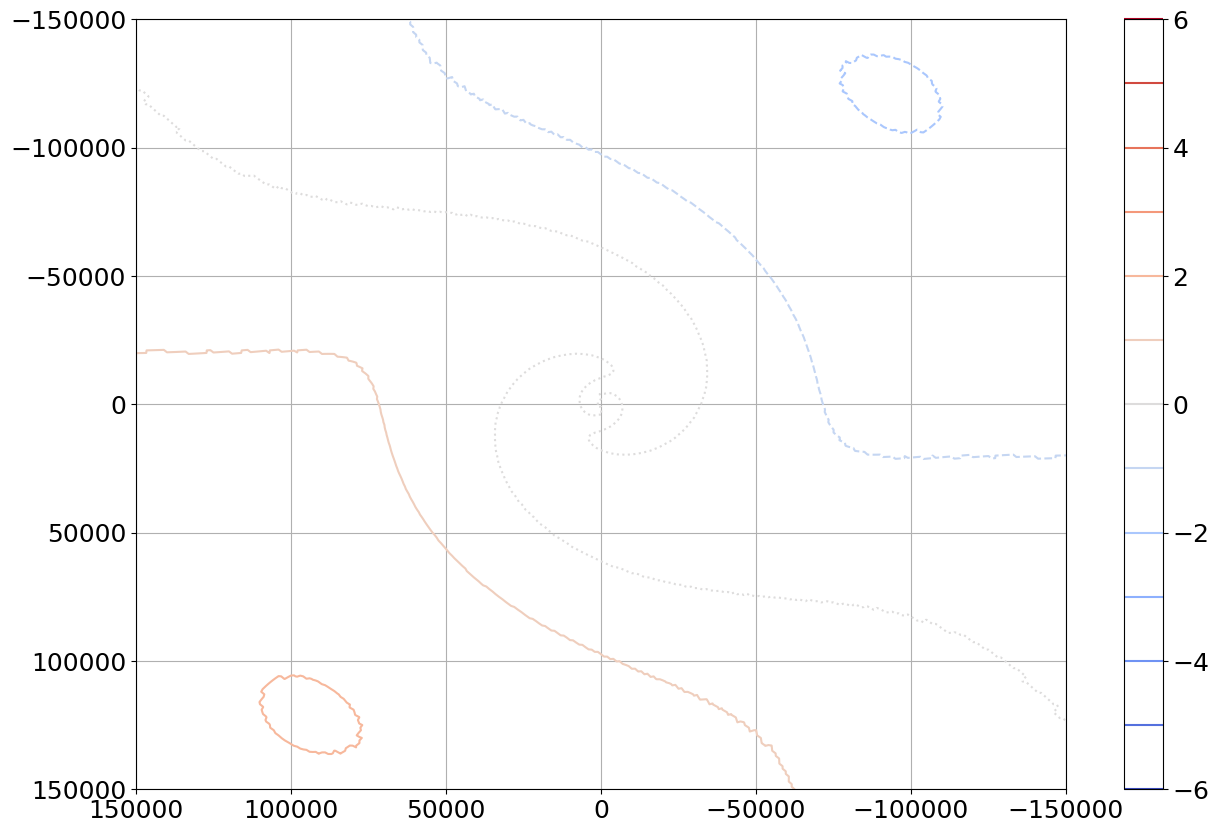

In [29]:
# 2nd column (v-1) - OK

cntr = plt.contour(x_ref, y_ref, np.array(a_car.v_1), levels=[-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6], vmin=-6, vmax=6, cmap='coolwarm')

# Override the linestyles based on the levels.
for line, lvl in zip(cntr.collections, cntr.levels):
    if lvl < 0:
        line.set_linestyle('--')
    elif lvl == 0:
        line.set_linestyle(':')
    else:
        line.set_linestyle('-')

# Grid
plt.colorbar()
plt.xlim(-150000, 150000)
plt.ylim(-150000, 150000)
plt.grid()

# Pour se ramener à Kepert on tourne a figure de 180° (pas très élégant comme solution mais bon):
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

/tmp/ipykernel_52228/2612076923.py:6: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for line, lvl in zip(cntr.collections, cntr.levels):


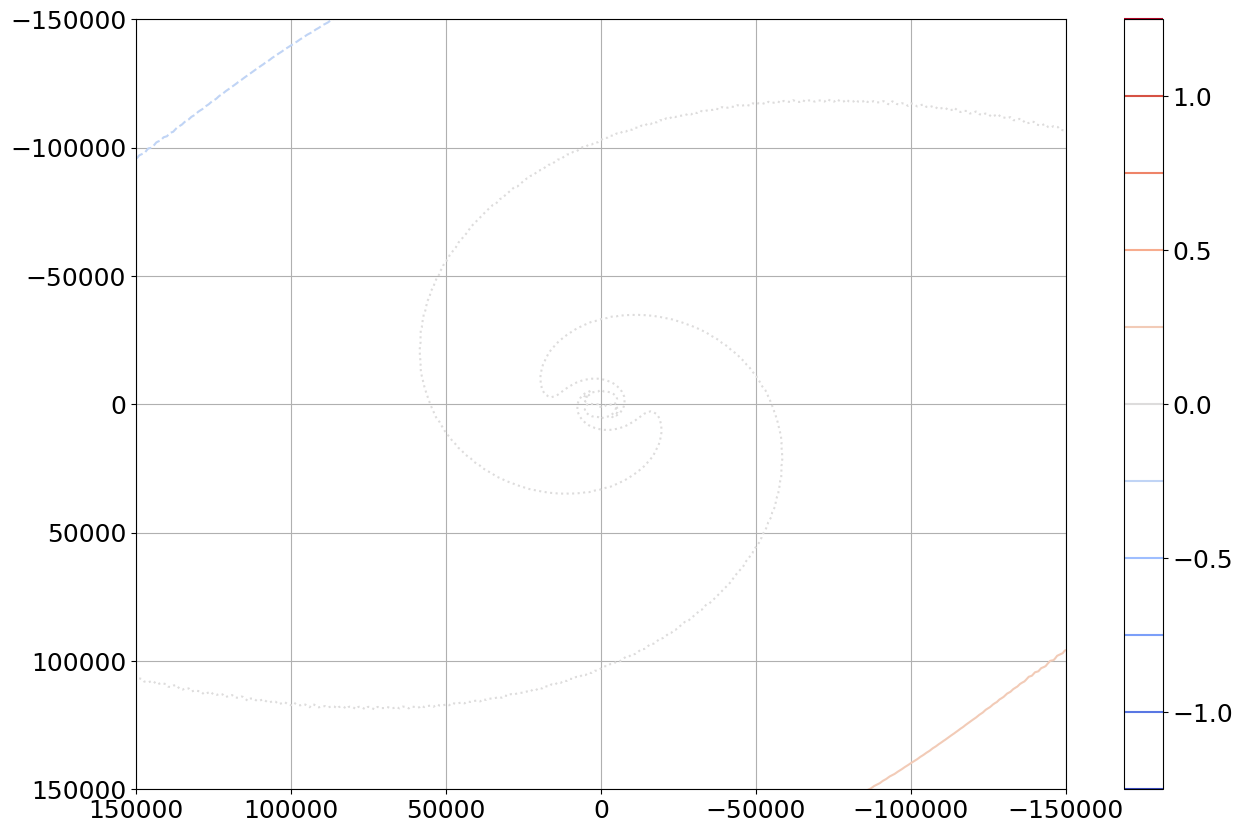

In [30]:
# 3rd column (u1) - OK

cntr = plt.contour(x_ref, y_ref, np.array(a_car.u1), levels=[-1.25, -1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 1.25],  vmin=-1.25, vmax=1.25, cmap='coolwarm')

# Override the linestyles based on the levels.
for line, lvl in zip(cntr.collections, cntr.levels):
    if lvl < 0:
        line.set_linestyle('--')
    elif lvl == 0:
        line.set_linestyle(':')
    else:
        line.set_linestyle('-')

# Grid
plt.colorbar()
plt.xlim(-150000, 150000)
plt.ylim(-150000, 150000)
plt.grid()

# Pour se ramener à Kepert on tourne a figure de 180° (pas très élégant comme solution mais bon):
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

/tmp/ipykernel_52228/2264685193.py:6: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for line, lvl in zip(cntr.collections, cntr.levels):


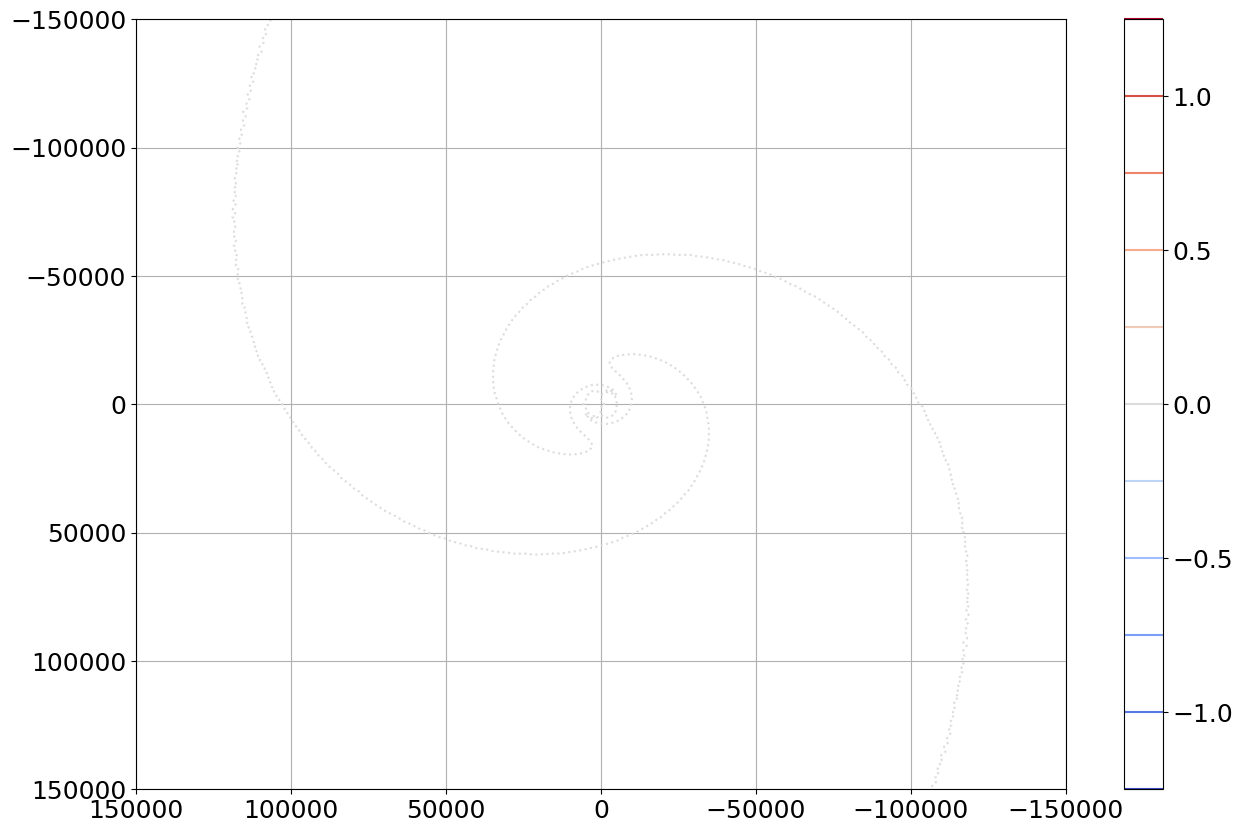

In [31]:
# 4th column (v1) - OK

cntr = plt.contour(x_ref, y_ref, np.array(a_car.v1), levels=[-1.25, -1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 1.25], vmin=-1.25, vmax=1.25, cmap='coolwarm')

# Override the linestyles based on the levels.
for line, lvl in zip(cntr.collections, cntr.levels):
    if lvl < 0:
        line.set_linestyle('--')
    elif lvl == 0:
        line.set_linestyle(':')
    else:
        line.set_linestyle('-')

# Grid
plt.colorbar()
plt.xlim(-150000, 150000)
plt.ylim(-150000, 150000)
plt.grid()

# Pour se ramener à Kepert on tourne a figure de 180° (pas très élégant comme solution mais bon):
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

### At z=2000m

/tmp/ipykernel_52228/462358277.py:6: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for line, lvl in zip(cntr.collections, cntr.levels):


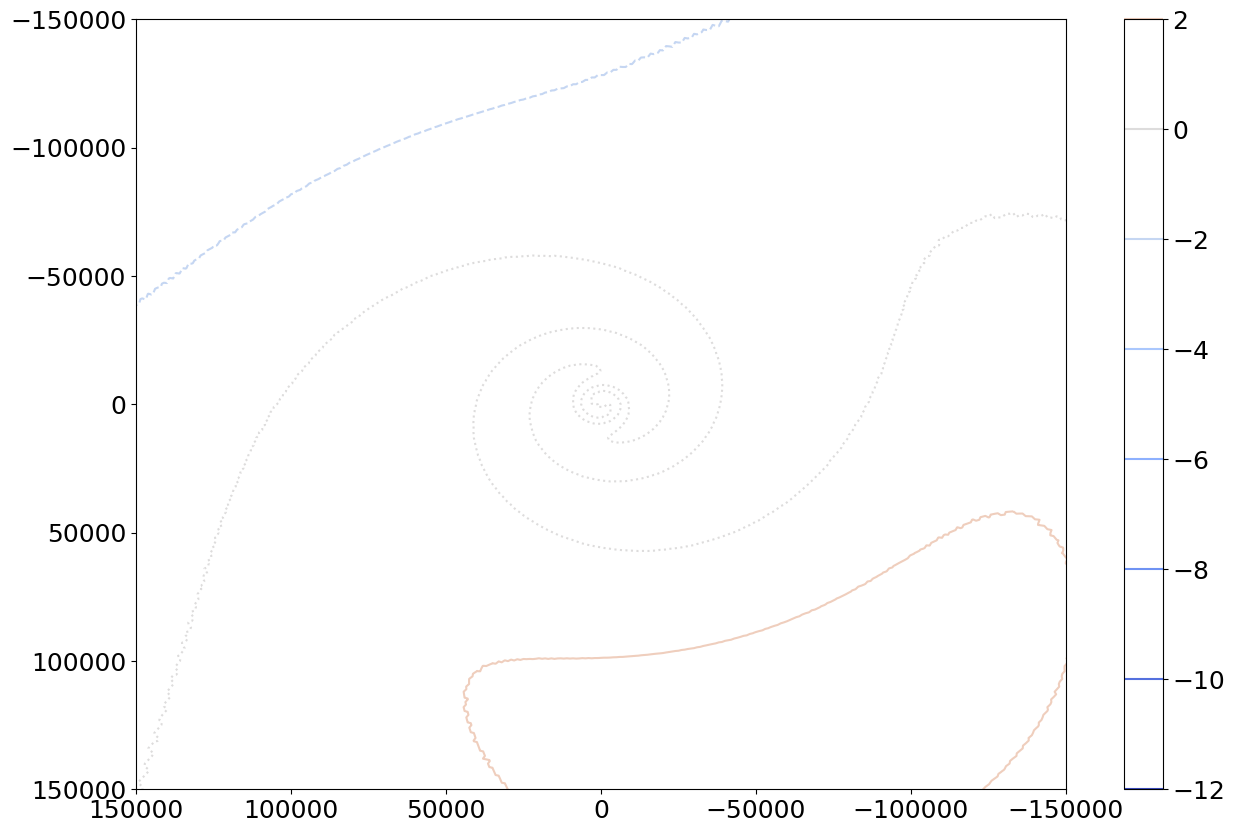

In [32]:
# 5th column (storm-relative radial flow)

cntr = plt.contour(x_ref, y_ref, np.array(kep_car.sel(z=2000).rad_wind), levels=[-12, -10, -8, -6, -4, -2, 0, 2], vmin=-12, vmax=12, cmap='coolwarm')

# Override the linestyles based on the levels.
for line, lvl in zip(cntr.collections, cntr.levels):
    if lvl < 0:
        line.set_linestyle('--')
    elif lvl == 0:
        line.set_linestyle(':')
    else:
        line.set_linestyle('-')

# Grid
plt.colorbar()
plt.xlim(-150000, 150000)
plt.ylim(-150000, 150000)

# Pour se ramener à Kepert on tourne a figure de 180° (pas très élégant comme solution mais bon):
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

/tmp/ipykernel_52228/1992787346.py:7: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for line, lvl in zip(cntr.collections, cntr.levels):


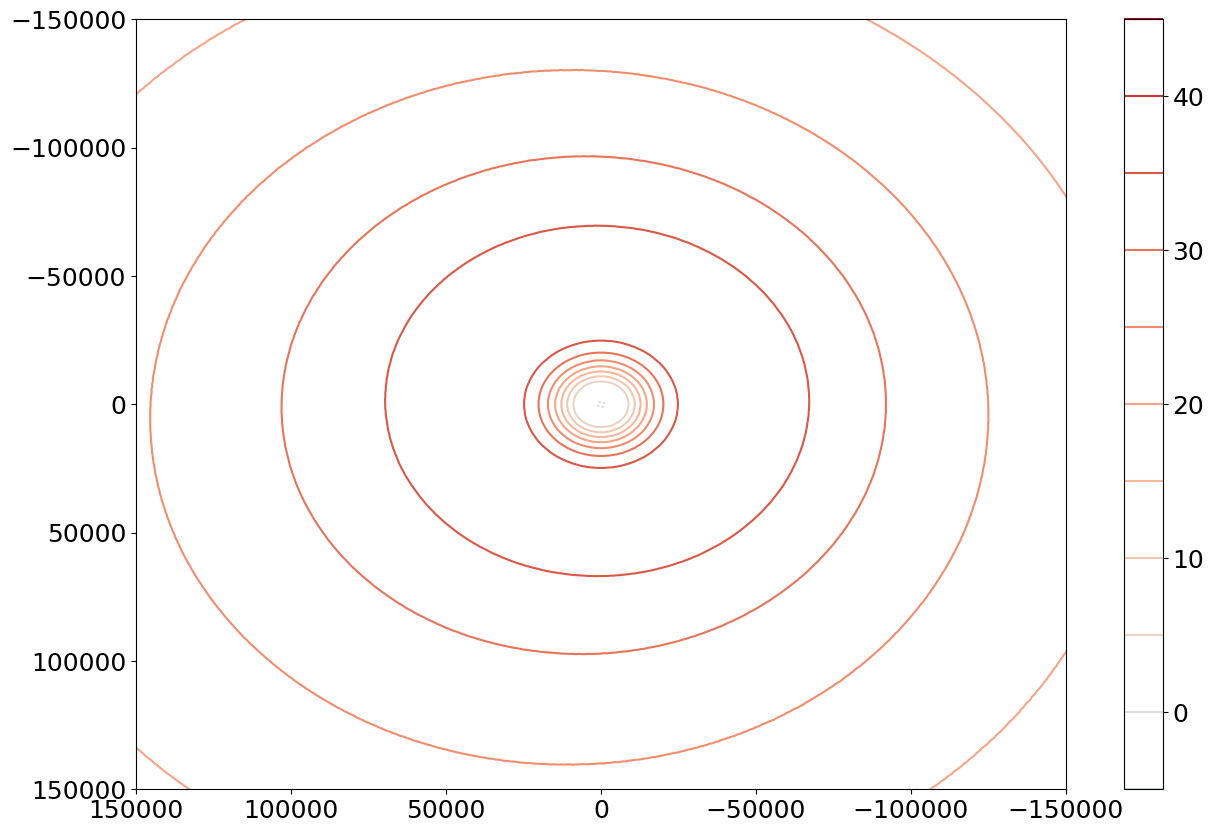

In [33]:
# 6th column (storm-relative azimuthal flow)

cntr = plt.contour(x_ref, y_ref, np.array(kep_car.sel(z=2000).tan_wind), levels=[-5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45], vmin=-45, vmax=45, cmap='coolwarm')


# Override the linestyles based on the levels.
for line, lvl in zip(cntr.collections, cntr.levels):
    if lvl < 0:
        line.set_linestyle('--')
    elif lvl == 0:
        line.set_linestyle(':')
    else:
        line.set_linestyle('-')

# Grid
plt.colorbar()
plt.xlim(-150000, 150000)
plt.ylim(-150000, 150000)

# Pour se ramener à Kepert on tourne a figure de 180° (pas très élégant comme solution mais bon):
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

In [34]:
u_1_K01, v_1_K01, u1_K01, v1_K01 = get_asymmetric_components_kepert2001(THs, Rs, Vs, Ut, K, C, fcr, z=2000)

a_pol = xr.Dataset(
    data_vars={
        'u_1': (('theta', 'rad'), u_1_K01),
        'v_1': (('theta', 'rad'), v_1_K01),
        'u1':  (('theta', 'rad'), u1_K01),
        'v1':  (('theta', 'rad'), v1_K01),
    },
    coords={
        'theta': np.rad2deg(ths),
        'rad': rs,
    }
)

a_car = xr.Dataset(
    data_vars={
        'u_1': (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(a_pol.u_1).flatten(), (x_ref, y_ref), method='nearest')),
        'v_1': (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(a_pol.v_1).flatten(), (x_ref, y_ref), method='nearest')),
        'u1':  (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(a_pol.u1).flatten(),  (x_ref, y_ref), method='nearest')),
        'v1':  (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(a_pol.v1).flatten(),  (x_ref, y_ref), method='nearest')),
    },
    coords={
        'x': dim_ref,
        'y': dim_ref,
    }
)

/tmp/ipykernel_52228/436064675.py:6: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for line, lvl in zip(cntr.collections, cntr.levels):


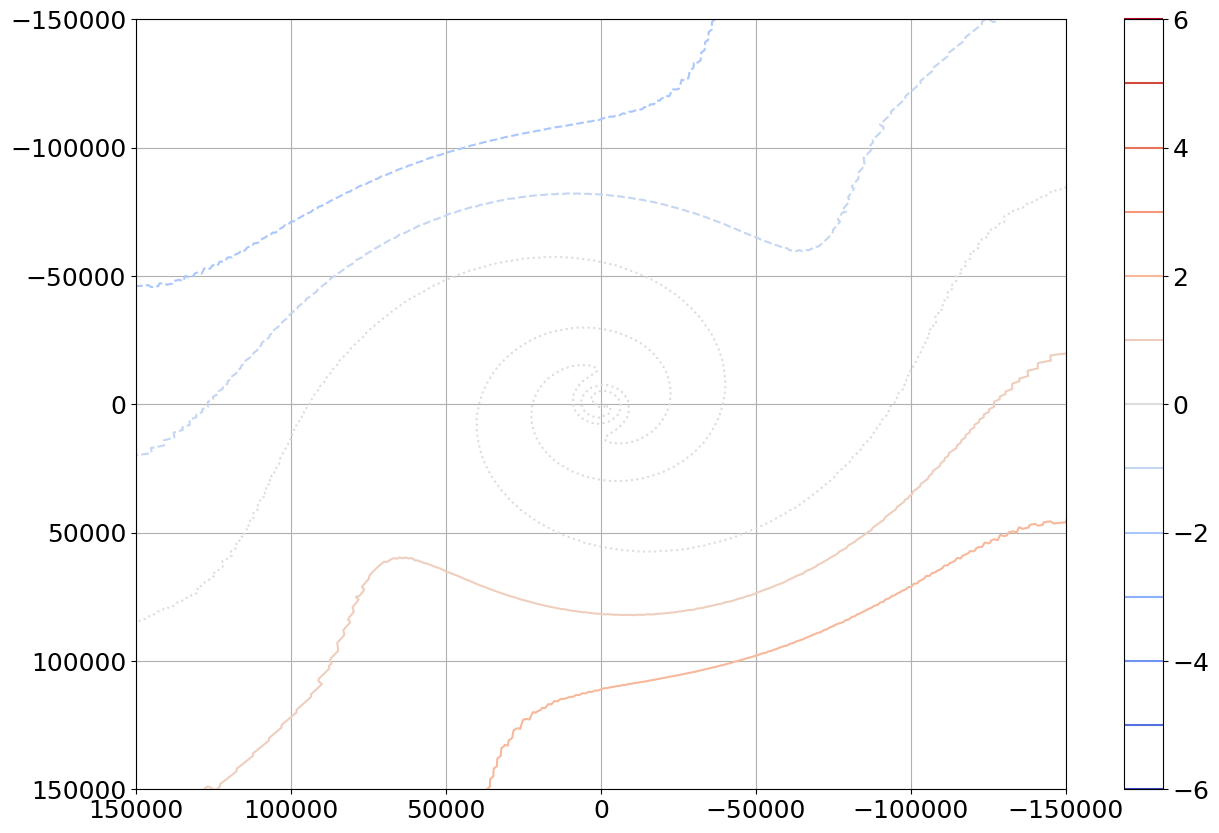

In [35]:
# 1st column (u-1) - OK

cntr = plt.contour(x_ref, y_ref, np.array(a_car.u_1), levels=[-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6], vmin=-6, vmax=6, cmap='coolwarm')

# Override the linestyles based on the levels.
for line, lvl in zip(cntr.collections, cntr.levels):
    if lvl < 0:
        line.set_linestyle('--')
    elif lvl == 0:
        line.set_linestyle(':')
    else:
        line.set_linestyle('-')

# Grid
plt.colorbar()
plt.xlim(-150000, 150000)
plt.ylim(-150000, 150000)
plt.grid()

# Pour se ramener à Kepert on tourne a figure de 180° (pas très élégant comme solution mais bon):
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

/tmp/ipykernel_52228/3852200409.py:6: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for line, lvl in zip(cntr.collections, cntr.levels):


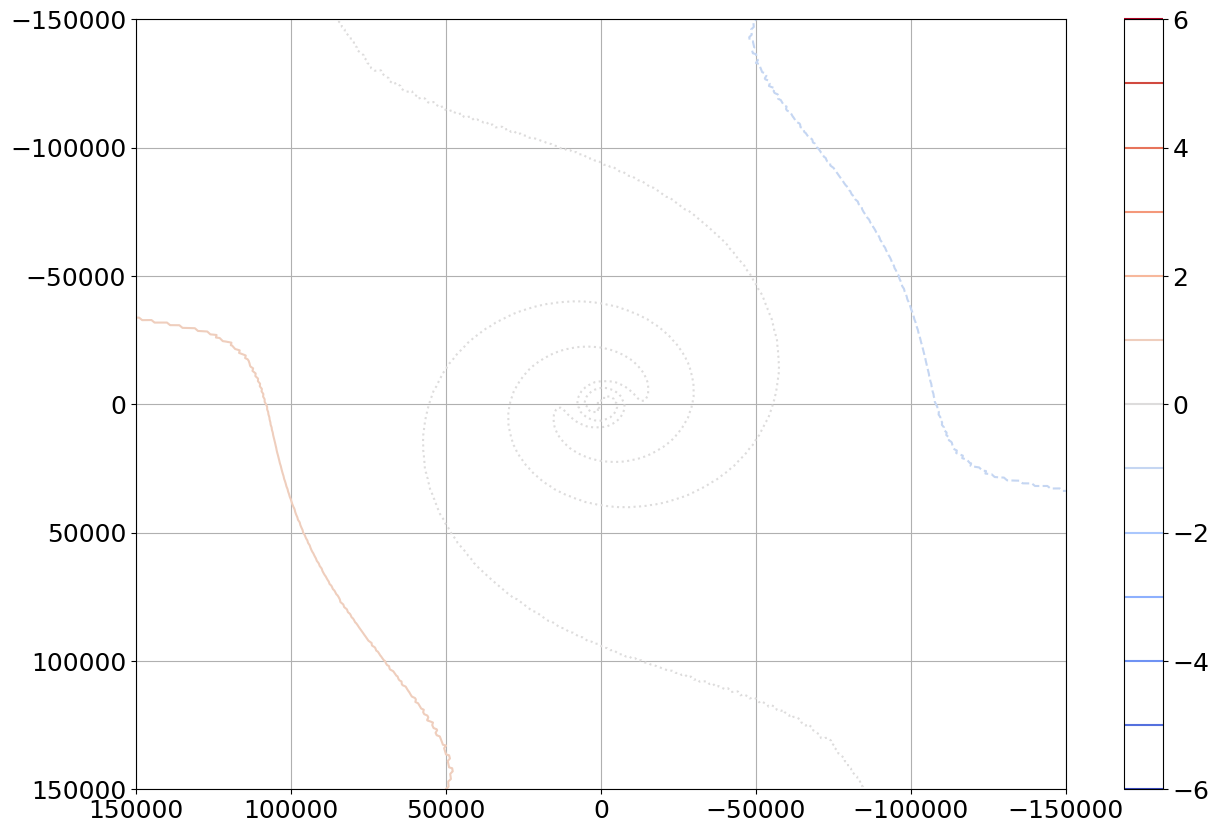

In [36]:
# 2nd column (v-1) - OK

cntr = plt.contour(x_ref, y_ref, np.array(a_car.v_1), levels=[-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6], vmin=-6, vmax=6, cmap='coolwarm')

# Override the linestyles based on the levels.
for line, lvl in zip(cntr.collections, cntr.levels):
    if lvl < 0:
        line.set_linestyle('--')
    elif lvl == 0:
        line.set_linestyle(':')
    else:
        line.set_linestyle('-')

# Grid
plt.colorbar()
plt.xlim(-150000, 150000)
plt.ylim(-150000, 150000)
plt.grid()

# Pour se ramener à Kepert on tourne a figure de 180° (pas très élégant comme solution mais bon):
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

/tmp/ipykernel_52228/2612076923.py:6: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for line, lvl in zip(cntr.collections, cntr.levels):


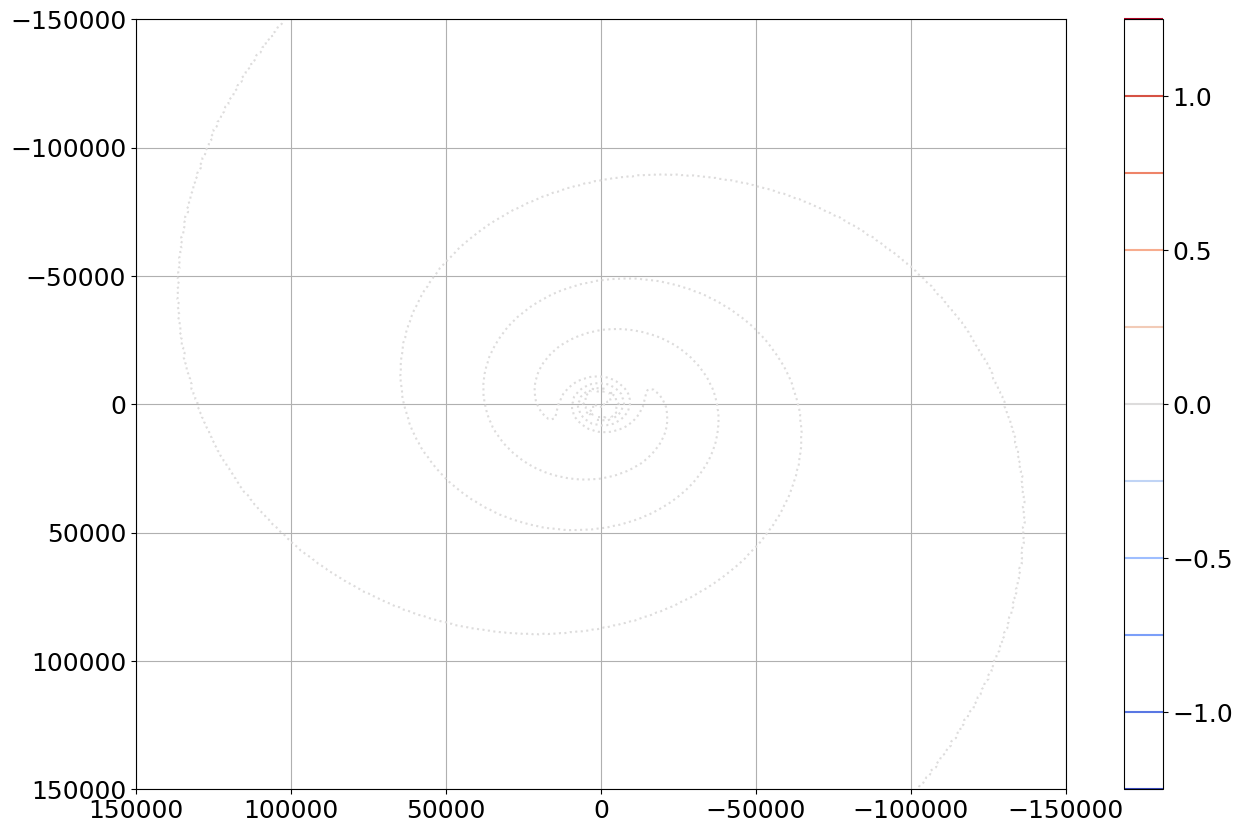

In [37]:
# 3rd column (u1) - OK

cntr = plt.contour(x_ref, y_ref, np.array(a_car.u1), levels=[-1.25, -1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 1.25],  vmin=-1.25, vmax=1.25, cmap='coolwarm')

# Override the linestyles based on the levels.
for line, lvl in zip(cntr.collections, cntr.levels):
    if lvl < 0:
        line.set_linestyle('--')
    elif lvl == 0:
        line.set_linestyle(':')
    else:
        line.set_linestyle('-')

# Grid
plt.colorbar()
plt.xlim(-150000, 150000)
plt.ylim(-150000, 150000)
plt.grid()

# Pour se ramener à Kepert on tourne a figure de 180° (pas très élégant comme solution mais bon):
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

/tmp/ipykernel_52228/2264685193.py:6: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for line, lvl in zip(cntr.collections, cntr.levels):


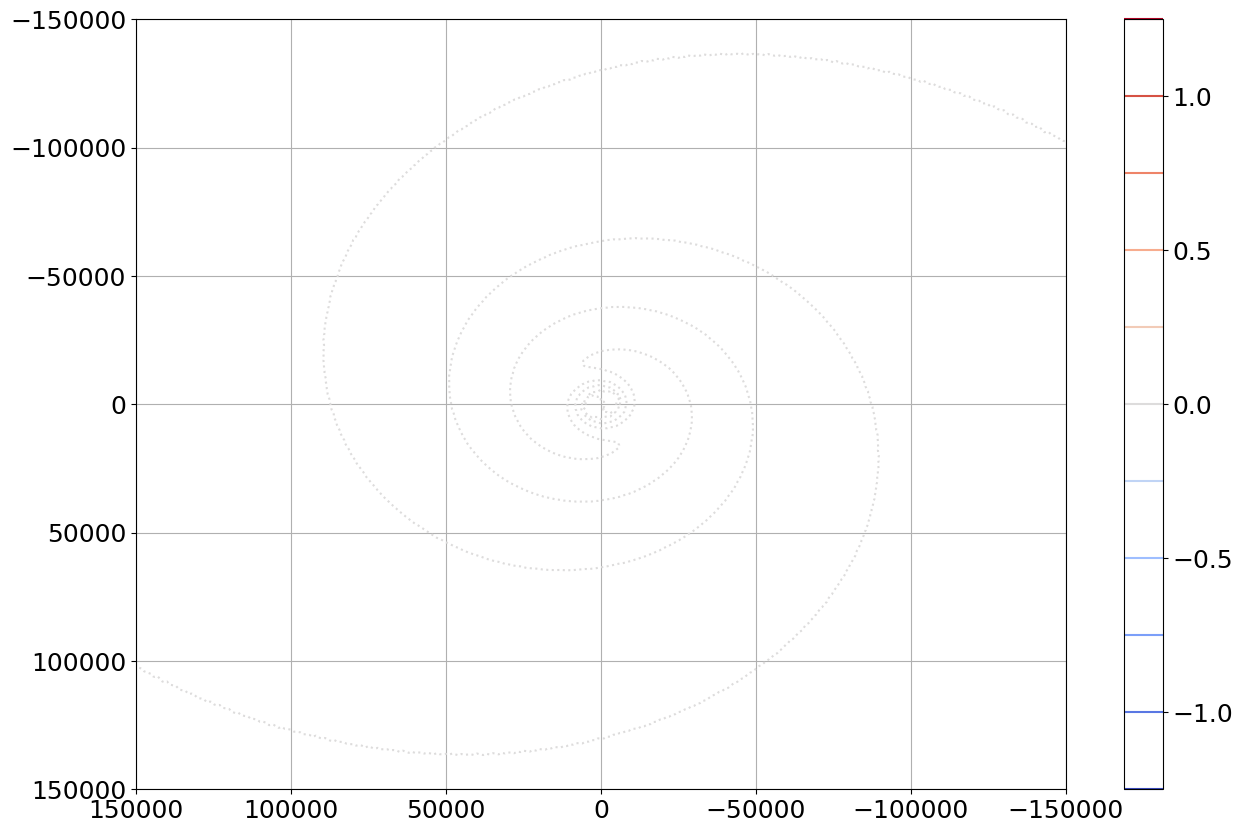

In [38]:
# 4th column (v1) - OK

cntr = plt.contour(x_ref, y_ref, np.array(a_car.v1), levels=[-1.25, -1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 1.25], vmin=-1.25, vmax=1.25, cmap='coolwarm')

# Override the linestyles based on the levels.
for line, lvl in zip(cntr.collections, cntr.levels):
    if lvl < 0:
        line.set_linestyle('--')
    elif lvl == 0:
        line.set_linestyle(':')
    else:
        line.set_linestyle('-')

# Grid
plt.colorbar()
plt.xlim(-150000, 150000)
plt.ylim(-150000, 150000)
plt.grid()

# Pour se ramener à Kepert on tourne a figure de 180° (pas très élégant comme solution mais bon):
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

### w at 2 km in storm-relative frame (Fig. 5a)

J'ai une petite différence entre ma vitesse w(z=2000) et celle de Kepert, de l'ordre de 0.05m/s. C'est peut-être dû au fait que j'intègre l'équation de continuité, tandis que Kepert utilise sûrement une forme analytique. Pour obtenir la forme analytique il me suffirait d'intégrer l'équation de continuité, comme c'est fait dans le Smith et Montgomery 2020 (mais ils ne le font qu'en axisymétrique). Demander à Kepert s'il peut me donner la forme analytique, ou gratter dans ses papiers, il l'a peut-être déjà fait. 

Augmenter la résolution dans le vecteur zs change un tout petit peu les résultats (de l'ordre de 0.01m/s), mais la différence ne vient très probablement pas de ça.

D'ailleurs, avec la formule d'Ekman (à re-coder au propre, en utilisant l'équation 28 de Kepert, j'ai une sacré différence de vitesses, i.e un facteur 2 ou 3)

TO CHECK? En tout cas, j'ai la bonne distribution en fonction de theta, ce qui confirme que j'ai bien implémenté mon passage en earth-relative frame.



In [43]:
def get_w(kep_pol, kep_car, zs):
    # Compute vertical velocity by integrating continuity equation
    dru_dr = (kep_pol.rad * kep_pol.rad_wind).differentiate('rad') # d(ru)/dr
    WS_POL = []
    WS_CAR = []
    for z in tqdm(zs):
        integral = dru_dr.sel(z=slice(None, z)).integrate('z')
        w_pol = - (1 / integral.rad) * integral
        WS_POL.append(w_pol)
        w_car = griddata((Xs.flatten(), Ys.flatten()), np.array(w_pol.transpose()).flatten(), (x_ref, y_ref), method='nearest')
        WS_CAR.append(xr.DataArray(w_car, coords={'x': dim_ref,'y': dim_ref}))
    kep_pol['w'] = xr.concat(WS_POL, dim='z')
    kep_car['w'] = xr.concat(WS_CAR, dim='z')
    return kep_pol, kep_car

In [44]:
kep_pol, kep_car = get_w(kep_pol, kep_car, zs)

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_52228/1116580681.py:6: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for line, lvl in zip(cntr.collections, cntr.levels):


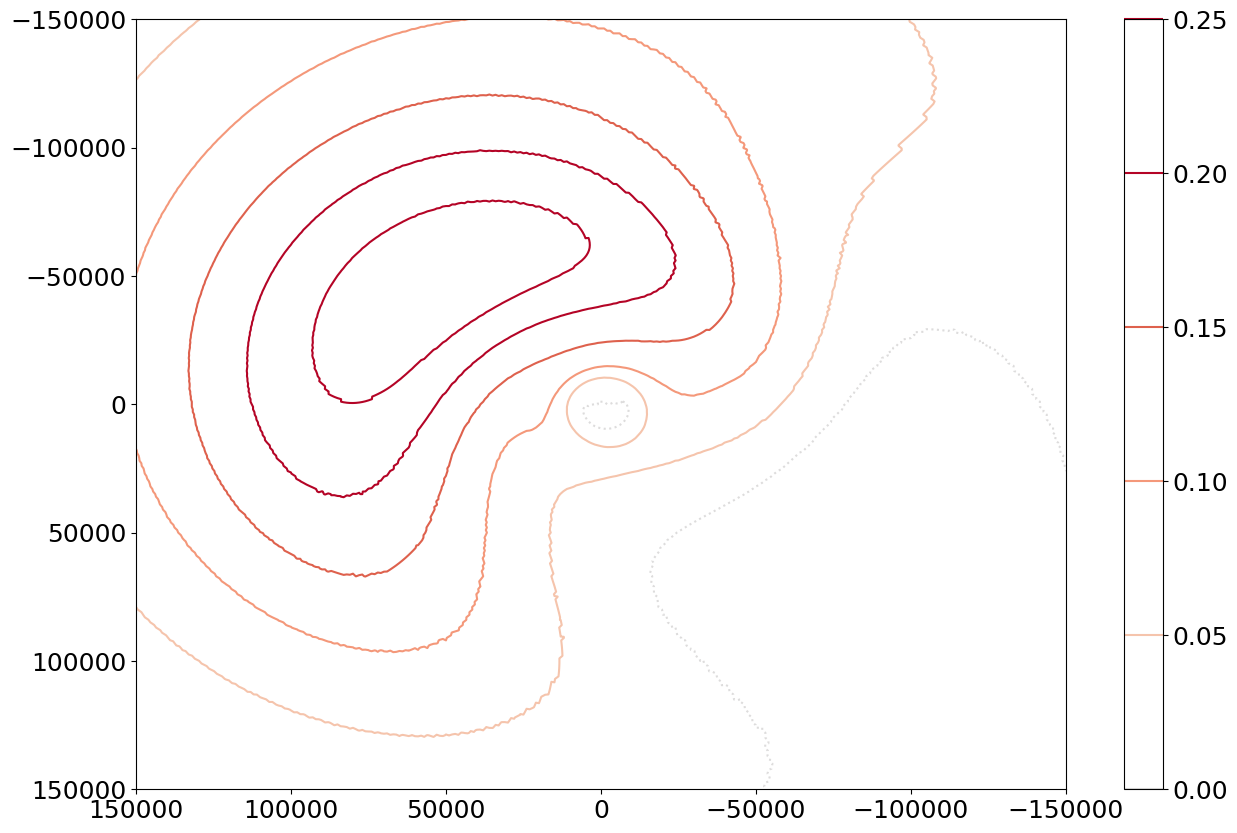

In [45]:
# Fig. 5a

cntr = plt.contour(x_ref, y_ref, np.array(kep_car.sel(z=2000).w), levels=[0, 0.05, 0.1, 0.15, 0.2, 0.25], vmin=-0.2, vmax=0.2, cmap='coolwarm')

# Override the linestyles based on the levels.
for line, lvl in zip(cntr.collections, cntr.levels):
    if lvl < 0:
        line.set_linestyle('--')
    elif lvl == 0:
        line.set_linestyle(':')
    else:
        line.set_linestyle('-')

# Grid
plt.colorbar()
plt.xlim(-150000, 150000)
plt.ylim(-150000, 150000)

# Pour se ramener à Kepert on tourne a figure de 180° (pas très élégant comme solution mais bon):
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

### Surface wind reduction factor (Fig. 5b)

This is mostly to check that my earth-relative winds are correct

In [85]:
# FINAL MODEL
def kepert2001(THs, Rs, Vs, Ut, K, C, fcor, z):
    # Returns Kepert wind speeds
    u_K01   = u_BL(THs, Rs, Vs, Ut, K, C, fcor, z)
    v_K01   = v_BL(THs, Rs, Vs, Ut, K, C, fcor, z)  

    # Adds the translation speed
    Utu     = Ut * np.cos(THs) # Radial component of Ut
    Utv     = - Ut * np.sin(THs) # Tangential component of Ut
    # Utu = Utv = 0
    
    return u_K01 + Utu, v_K01 + Utv

In [86]:
def get_z_kepert(THs, Rs, ths, rs, zs, Vs, Ut, K, C, fcr):
    # # Estimate the wind at the top of the BL with the wind reduction factor
    # LINES TO UNCOMMENT, JUST FOR THE CHECKING NOTEBOOK
    # wrf          = wind_reduction_factor(Rs, Vs, K, C, fcr) # azimuthal wind
    # Vs_try       = Vs / wrf
    # And comment this line below instead:
    Vs_try = Vs

    # Apply Kepert's model at each z
    # TODO: Vectorize all my functions?
    U_K01, V_K01 = [], []
    for z in tqdm(zs):
        u_K01, v_K01 = kepert2001(THs, Rs, Vs_try, Ut, K, C, fcr, z) # Takes 3-4 seconds
        U_K01.append(u_K01)
        V_K01.append(v_K01)
    
    # Polar dataset
    kep_pol = xr.Dataset(
        data_vars={
            'wind_speed': (('z', 'theta', 'rad'), np.sqrt(np.array(V_K01) ** 2 + np.array(U_K01) ** 2)),
            'rad_wind':   (('z', 'theta', 'rad'), np.array(U_K01)),
            'tan_wind':   (('z', 'theta', 'rad'), np.array(V_K01)),
        },
        coords={
            'z': zs,
            'theta': np.rad2deg(ths),
            'rad': rs,
        }
    )
    kep_pol['inflow_angle'] = np.rad2deg(np.arctan((kep_pol.rad_wind / kep_pol.tan_wind))) # Inflow Angle Polar
    print('Polar dataset created.')

    # Cartesian dataset
    KEP_CARS = []
    for z in tqdm(zs): # Takes ~20 seconds
        kep_car = xr.Dataset(
            data_vars={
                'wind_speed':   (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.sel(z=z).wind_speed).flatten(),   (x_ref, y_ref), method='nearest')),
                'rad_wind':     (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.sel(z=z).rad_wind).flatten(),     (x_ref, y_ref), method='nearest')),
                'tan_wind':     (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.sel(z=z).tan_wind).flatten(),     (x_ref, y_ref), method='nearest')),
                'inflow_angle': (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.sel(z=z).inflow_angle).flatten(), (x_ref, y_ref), method='nearest')),
            },
            coords={
                'x': dim_ref,
                'y': dim_ref,
            }
        )
        KEP_CARS.append(kep_car)
    kep_car = xr.concat(KEP_CARS, 'z').assign_coords({'z': zs})
    print('Cartesian dataset created.')

    return kep_pol, kep_car

In [112]:
zs = np.linspace(0, 2000, 21)

In [113]:
### Apply Kepert
kep_pol, kep_car = get_z_kepert(THs, Rs, ths, rs, zs, Vs, Ut, K, C, fcr)

  0%|          | 0/21 [00:00<?, ?it/s]

Polar dataset created.


  0%|          | 0/21 [00:00<?, ?it/s]

Cartesian dataset created.


In [114]:
# Surface wind factor
# What is the definition used by Kepert exactl?
sfc_wnd_rdc_fcr = kep_car.wind_speed.sel(z=0) / kep_car.wind_speed.sel(z=2000)

In [115]:
# swrf_pol = kep_pol.wind_speed.sel(z=0) / (V + 0.0000001)
# swrf_car = griddata((Xs.flatten(), Ys.flatten()), np.array(swrf_pol).flatten(),   (x_ref, y_ref), method='nearest')

/tmp/ipykernel_52228/27027741.py:6: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for line, lvl in zip(cntr.collections, cntr.levels):


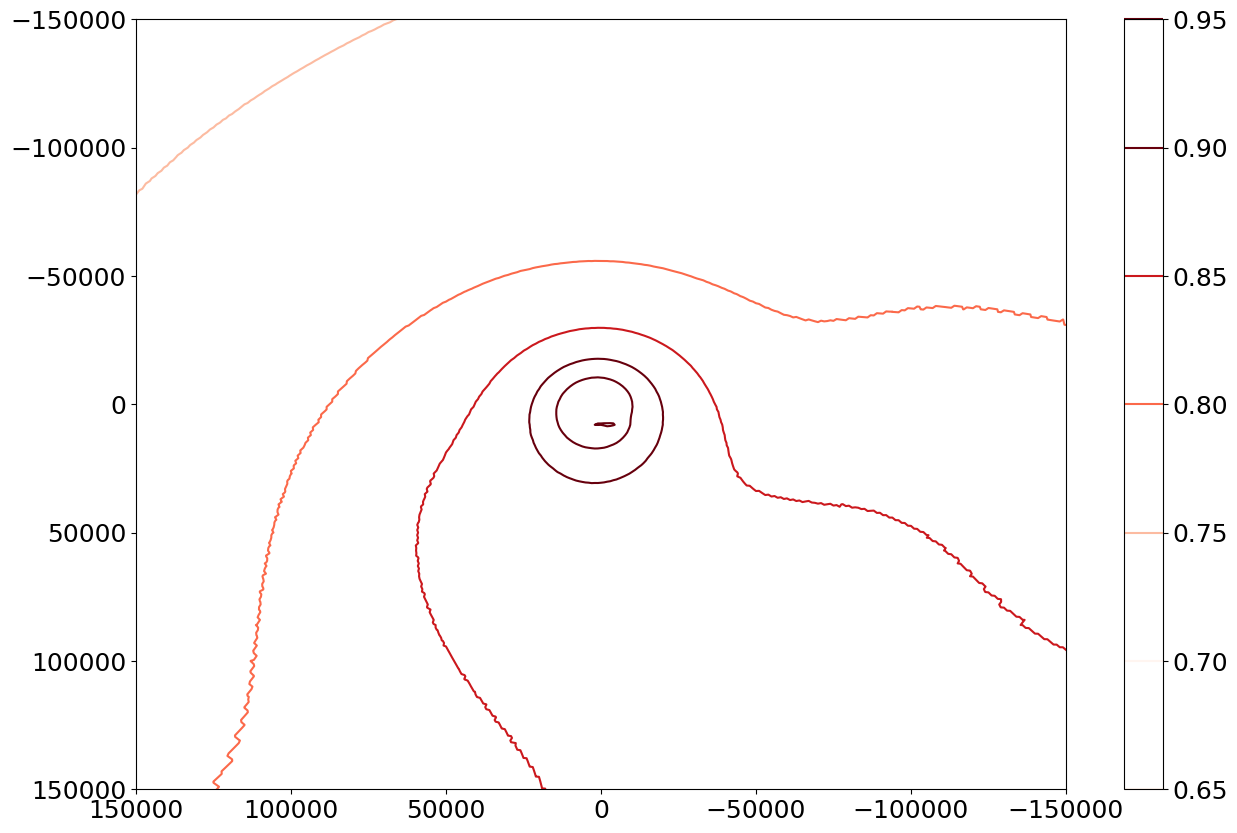

In [116]:
# Fig. 5b

cntr = plt.contour(x_ref, y_ref, np.array(sfc_wnd_rdc_fcr), levels=[0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95], vmin=0.7, vmax=0.9, cmap='Reds')

# Override the linestyles based on the levels.
for line, lvl in zip(cntr.collections, cntr.levels):
    if lvl < 0:
        line.set_linestyle('--')
    elif lvl == 0:
        line.set_linestyle(':')
    else:
        line.set_linestyle('-')

# Grid
plt.colorbar()
plt.xlim(-150000, 150000)
plt.ylim(-150000, 150000)

# Pour se ramener à Kepert on tourne a figure de 180° (pas très élégant comme solution mais bon):
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

In [121]:
### TRY to estimate jet factor (Fig. 4)
# I don't really know the exact definition used by Kepert

In [118]:
jet_factor = kep_car.wind_speed.max(dim='z') / kep_car.wind_speed.sel(z=2000)

/tmp/ipykernel_52228/2217818172.py:6: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for line, lvl in zip(cntr.collections, cntr.levels):


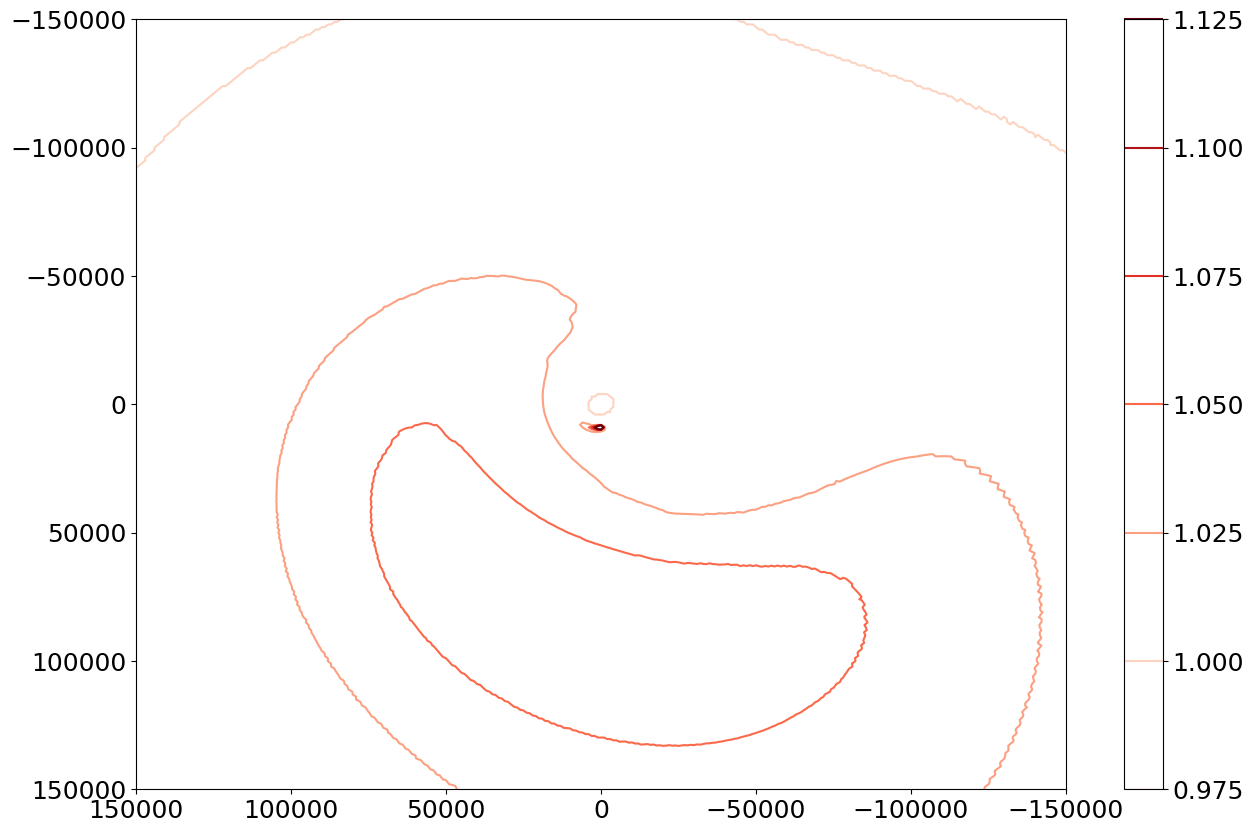

In [119]:
# Fig. 4a

cntr = plt.contour(x_ref, y_ref, np.array(jet_factor), levels=[0.975, 1, 1.025, 1.05, 1.075, 1.1, 1.125], cmap='Reds')

# Override the linestyles based on the levels.
for line, lvl in zip(cntr.collections, cntr.levels):
    if lvl < 0:
        line.set_linestyle('--')
    elif lvl == 0:
        line.set_linestyle(':')
    else:
        line.set_linestyle('-')

# Grid
plt.colorbar()
plt.xlim(-150000, 150000)
plt.ylim(-150000, 150000)

# Pour se ramener à Kepert on tourne a figure de 180° (pas très élégant comme solution mais bon):
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()